Notebook for exploring how to read in and handle transmittance data.

@author: David Clemens-Sewall

In [133]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import CubicSpline

%matplotlib inline

In [468]:
def read_spectrum_file(filepath):
    """
    Reads a spectrum file from MSDA_XE format and puts it into a long pandas dataframe
    
    Parameters
    ----------
    filepath: str
        Path object for the spectrum file to read in
    
    Returns
    -------
    Pandas DataFrame with the relevant data from the file in long format
    
    """
    
    # Read file into a list with each line as an entry
    with open(filepath, 'r') as f:
        ls_file = f.readlines()
        
    if ls_file[0]!='[Spectrum]\n':
        raise RuntimeError('Not a spectrum file: ' + filepath)

    # Pull the attributes into a dictionary
    att_dict = {}
    for i in range(len(ls_file)):
        if ls_file[i] in ['[Spectrum]\n', '[Attributes]\n', '[END] of [Attributes]\n']:
            continue
        elif ls_file[i] == '[DATA]\n':
            break
        else:
            att_dict[ls_file[i].split('=')[0].strip()] = ls_file[i].split('=')[1].strip()
            
    # If there are no comments, return None
    if (att_dict['Comment'] == '') & (att_dict['CommentSub1'] == '') & (att_dict['CommentSub2'] == ''):
        return None
    
    # Fix typos in attributes
    if att_dict['CommentSub2'] == 'az990':
        att_dict['CommentSub2'] = 'az90'

    # Create column names for data
    col_names = [att_dict['Unit1'].split(maxsplit=2)[2].replace(' ', '_').lower(),
                 att_dict['Unit2'].split(maxsplit=2)[2].replace(' ', '_'),
                 att_dict['Unit3'].split(maxsplit=2)[2].replace(' ', '_'),
                 att_dict['Unit4'].split(maxsplit=2)[2].replace(' ', '_'),]

    # Read data in with pandas
    # Note that we skip the first row which is just the integration time
    df_in = pd.read_csv(filepath, sep='\s+', header=None, names=col_names, skiprows=i+2, nrows=len(ls_file)-i-4,
                       na_values='-NAN')

    if att_dict['IDDevice'] in ['SAM_881D', 'SAM_8333']:
        if (bool(re.search(r"AL", att_dict['CommentSub3']))
            | ((att_dict['Comment'] == 'station1') & (att_dict['CommentSub1'] == 'coring') 
               & (pd.Timestamp(att_dict['DateTime']) > pd.Timestamp('2025-07-10 11:21:00'))
               & (pd.Timestamp(att_dict['DateTime']) < pd.Timestamp('2025-07-10 23:59:00')))
            | ((att_dict['Comment'] == 'station1') & (att_dict['CommentSub1'] == 'ocn_pond') 
               & (pd.Timestamp(att_dict['DateTime']) > pd.Timestamp('2025-07-10 15:43:00')))):
            df_in.rename(columns={col_names[1]: col_names[1].replace('Intensity', 'Reflected'),
                                  col_names[2]: 'Reflected_' + col_names[2],
                                  col_names[3]: 'Reflected_' + col_names[3]}, inplace=True)
        else:
            df_in.rename(columns={col_names[1]: col_names[1].replace('Intensity', 'Transmitted'),
                                  col_names[2]: 'Transmitted_' + col_names[2],
                                  col_names[3]: 'Transmitted_' + col_names[3]}, inplace=True)
    elif att_dict['IDDevice']=='SAM_881E':
        df_in.rename(columns={col_names[1]: col_names[1].replace('Intensity', 'Incident'),
                              col_names[2]: 'Incident_' + col_names[2],
                              col_names[3]: 'Incident_' + col_names[3]}, inplace=True)

    # Convert to long form
    df_long = df_in.melt(id_vars='wavelength_nm')

    # Add pressure and inclination data if present
    if att_dict['IDDevice'] in ['SAM_881D', 'SAM_8333']:
        inc_press = np.zeros(4)*np.NaN
        if att_dict['InclValid']=='1':
            inc_press[0] = float(att_dict['InclV'])
            inc_press[1] = float(att_dict['InclX'])
            inc_press[2] = float(att_dict['InclY'])
        if att_dict['PressValid']=='1':
            inc_press[3] = float(att_dict['Pressure'])
        df_long = pd.concat([df_long, 
                             pd.DataFrame(data={'wavelength_nm': [np.NaN, np.NaN, np.NaN, np.NaN],
                                          'variable': ['InclV', 'InclX', 'InclY', 'Pressure'],
                                          'value': inc_press})])

    # Add timestamp, station, location, azimuth, depth, and repetition columns
    df_long['timestamp_utc'] = pd.Timestamp(att_dict['DateTime'], tz='UTC')
    
    # Need to handle exceptions to pattern
    if att_dict['DateTime'][:10] == '2025-07-12':
        df_long['station'] = att_dict['CommentSub1'][-1]
        df_long['location'] = att_dict['CommentSub2']
        if att_dict['CommentSub3'][-2:] == 'AL':
            df_long['azimuth'] = att_dict['CommentSub3'][:-2]
        else:
            df_long['azimuth'] = att_dict['CommentSub3']
    elif (att_dict['DateTime'][:10] == '2025-07-16') and (att_dict['CommentSub1'] == 'SNpond'):
        df_long['station'] = att_dict['Comment'][-1]
        df_long['location'] = att_dict['CommentSub1']
        df_long['azimuth'] = att_dict['CommentSub2']
    else:
        df_long['station'] = att_dict['Comment'][-1]
        df_long['location'] = att_dict['CommentSub1']
        # Extract numbers from CommentSub2 for azimuth
        comment2_numbers = re.findall("(\d+)", att_dict['CommentSub2'])
        if len(comment2_numbers) != 1:
            raise RuntimeError('Comment 2 contains more than one set of numbers, may not be azimuth: '+filepath)
        else:
            df_long['azimuth'] = comment2_numbers[0]
    
    df_long['type'] = 'U'
    df_long['depth'] = np.NaN
    df_long['repetition'] = int(0)

    # Set index and return
    return df_long.set_index(
        ['timestamp_utc', 'station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm', 'variable'])

def read_paired_spectra(filepath_pair):
    """
    Reads in a pair of coincident spectra and computes the albedo or transmittance
    
    Parameters
    ----------
    filepath_pair: tuple
        Pair of paths to coincident spectra
        
    Returns
    -------
    Pandas DataFrame containing the data from each spectra and a ratio spectrum (albedo or transmittance)
    
    """
    
    # Read in paired spectra
    fp_1, fp_2 = filepath_pair
    df_1 = read_spectrum_file(fp_1)
    df_2 = read_spectrum_file(fp_2)
    
    # If both are None, return None
    if (df_1 is None) | (df_2 is None):
        if (df_1 is None) & (df_2 is None):
            return None
        else:
            raise RuntimeError("Only one of the following is missing comments: " + fp_1 + fp_2)

    # The instruments don't actually measure exactly the same wavelengths... so we need to interpolate
    var_list = ["Incident_mW/(m^2_nm)", "Reflected_mW/(m^2_nm)", "Transmitted_mW/(m^2_nm)",
               "Incident_Status", "Reflected_Status", "Transmitted_Status"]
    wvs_interp = np.linspace(320, 950, 190)
    merge_dict = {}
    
    # Interpolate each spectrum and combine
    df_temp_1 = df_1.query('variable in @var_list & @notna_var(value)').reset_index(level='variable').pivot(columns='variable', values='value')
    df_temp_1.dropna(inplace=True)
    for col_name in df_temp_1.columns:
        spl = CubicSpline(df_temp_1.index.get_level_values('wavelength_nm').values, df_temp_1[col_name].values)
        merge_dict[col_name] = spl(wvs_interp)
    df_temp_2 = df_2.query('variable in @var_list & @notna_var(value)').reset_index(level='variable').pivot(columns='variable', values='value')
    df_temp_2.dropna(inplace=True)
    for col_name in df_temp_2.columns:
        spl = CubicSpline(df_temp_2.index.get_level_values('wavelength_nm').values, df_temp_2[col_name].values)
        merge_dict[col_name] = spl(wvs_interp)
    df_merge = pd.DataFrame(data=merge_dict, index=wvs_interp)
    df_merge.index.name = 'wavelength_nm'

    # Compute ratio spectrum and set type in original dataframes
    if "Reflected_mW/(m^2_nm)" in df_merge.columns:
        df_merge['Albedo'] = df_merge["Reflected_mW/(m^2_nm)"] / df_merge["Incident_mW/(m^2_nm)"]
        df_merge['Albedo_Status'] = df_merge['Reflected_Status'] + df_merge['Incident_Status']
        df_merge.drop(columns=["Reflected_mW/(m^2_nm)", "Incident_mW/(m^2_nm)", 'Reflected_Status', 'Incident_Status'],
                     inplace=True)
        df_1.index = df_1.index.set_levels(['A']*df_1.size, level='type', verify_integrity=False)
        df_2.index = df_2.index.set_levels(['A']*df_2.size, level='type', verify_integrity=False)
    elif "Transmitted_mW/(m^2_nm)" in df_merge.columns:
        df_merge['Transmittance'] = df_merge["Transmitted_mW/(m^2_nm)"] / df_merge["Incident_mW/(m^2_nm)"]
        df_merge['Transmittance_Status'] = df_merge['Transmitted_Status'] + df_merge['Incident_Status']
        df_merge.drop(columns=["Transmitted_mW/(m^2_nm)", "Incident_mW/(m^2_nm)", 'Transmitted_Status', 'Incident_Status'],
                     inplace=True)
        df_1.index = df_1.index.set_levels(['T']*df_1.size, level='type', verify_integrity=False)
        df_2.index = df_2.index.set_levels(['T']*df_2.size, level='type', verify_integrity=False)
    else:
        raise RuntimeError('Missing Transmitted or Reflected from ' + fp_1 + fp_2)

    # Add values for the first six elements of index
    for i in range(7):
        name = df_1.index.names[i]
        val = df_1.index.get_level_values(name).unique()
        if len(val) != 1:
            raise RuntimeError('Nonunique time, site, location, azimuth, type, depth index for: '+fp_1)
        else:
            df_merge[name] = val[0]

    # Return to long format
    df_merge = df_merge.reset_index().melt(id_vars=
        ['timestamp_utc', 'station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm']
        ).set_index(['timestamp_utc', 'station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm', 'variable'])

    # Combine all data
    return pd.concat([df_1, df_2, df_merge])

def convert_00_to_a1(data_path, project_name):
    """
    Converts all of the raw data (00) in a location directory into a1.
    
    Parameters
    ----------
    data_path: str or path-like
        Path to directory where all the project directories are stored.
    project_name: str
        Name of the project to import (also the directory name)
    
    Returns
    -------
    Pandas DataFrame with all data formatted into a1 long format
    
    """
    
    # Identify measurement pairs
    data_level = '00'
    ls_filenames = os.listdir(os.path.join(data_path, project_name, data_level))
    ls_lonely = []
    ls_pairs = []
    for filename in ls_filenames:
        if re.search('SPECTRUM_CALIBRATED', filename):
            lonely = True
            for i in range(len(ls_lonely)):
                other_filename = ls_lonely[i]
                if filename[:38]==other_filename[:38]:
                    ls_pairs.append((os.path.join(data_path, project_name, data_level, filename),
                                     os.path.join(data_path, project_name, data_level, ls_lonely.pop(i))))
                    lonely = False
                    break
            if lonely:
                ls_lonely.append(filename)

    # Load each dataset and set the repetition correctly
    ls_df = []
    first = True
    for i in range(len(ls_pairs)):
        ls_df.append(read_paired_spectra(ls_pairs[i]))
        
        if (ls_df[i] is not None):
            # On the first one just copy the multiindex.
            if first:
                ls_df[i].index = ls_df[i].index.set_levels(np.ones(ls_df[i].size, dtype=np.int64), level='repetition',
                                                          verify_integrity=False)
                ind = ls_df[i].index.droplevel(['timestamp_utc', 'wavelength_nm', 'variable']).unique()
                first = False
            else:
                # Check if we have prior repetitions at this site
                new_ind = ls_df[i].index.droplevel(['timestamp_utc', 'wavelength_nm', 'variable', 'repetition']).unique()
                ind_mask = ind.droplevel('repetition').isin(new_ind) # boolean array of matching indices
                if ind_mask.any():
                    rep = ind[ind_mask].get_level_values('repetition').max() + 1
                else:
                    rep = 1
                # Update repetition values in new dataframe
                ls_df[i].index = ls_df[i].index.set_levels(rep*np.ones(ls_df[i].size, dtype=np.int64), level='repetition',
                                                          verify_integrity=False)
                # Add the new index to ind
                ind = ind.append(ls_df[i].index.droplevel(['timestamp_utc', 'wavelength_nm', 'variable']).unique())

    df_a1 = pd.concat(ls_df)
    
    return df_a1

# Try loading each set of measurements

In [274]:
# paths
data_path = os.path.join('..', 'data')

In [349]:
project_name = '20250710-r1-coring'
df_a1 = convert_00_to_a1(data_path, project_name)

<Axes: xlabel='wavelength_nm', ylabel='value'>

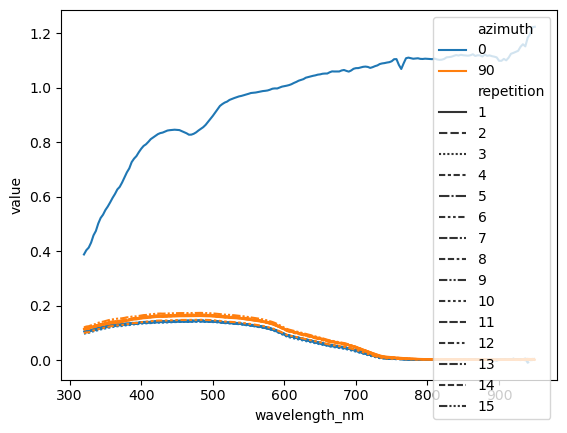

In [340]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Transmittance" & type=="T"'))

<Axes: xlabel='wavelength_nm', ylabel='value'>

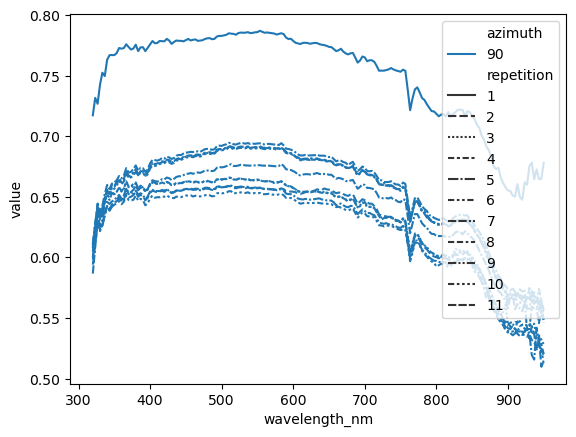

In [341]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Albedo" & type=="A"'))

In [283]:
project_name = '20250710-r1-ocn_pond'
df_a1 = convert_00_to_a1(data_path, project_name)

<Axes: xlabel='wavelength_nm', ylabel='value'>

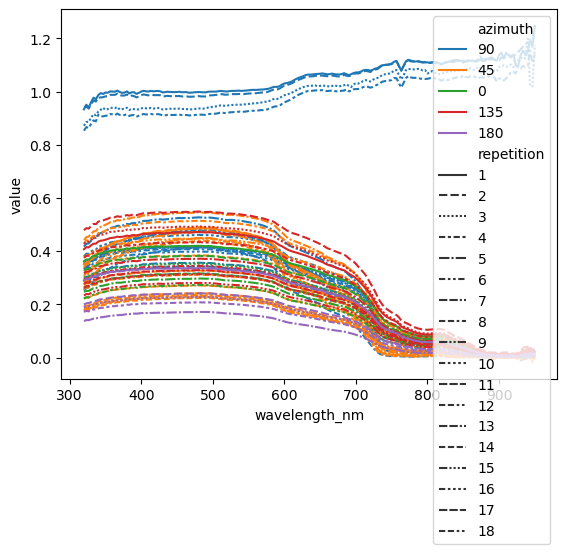

In [284]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Transmittance" & type=="T"'))

<Axes: xlabel='wavelength_nm', ylabel='value'>

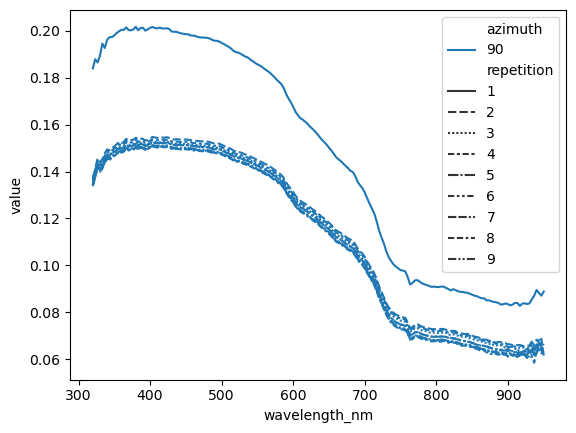

In [285]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Albedo" & type=="A"'))

In [292]:
project_name = '20250712-r1-ssl'
df_a1 = convert_00_to_a1(data_path, project_name)

<Axes: xlabel='wavelength_nm', ylabel='value'>

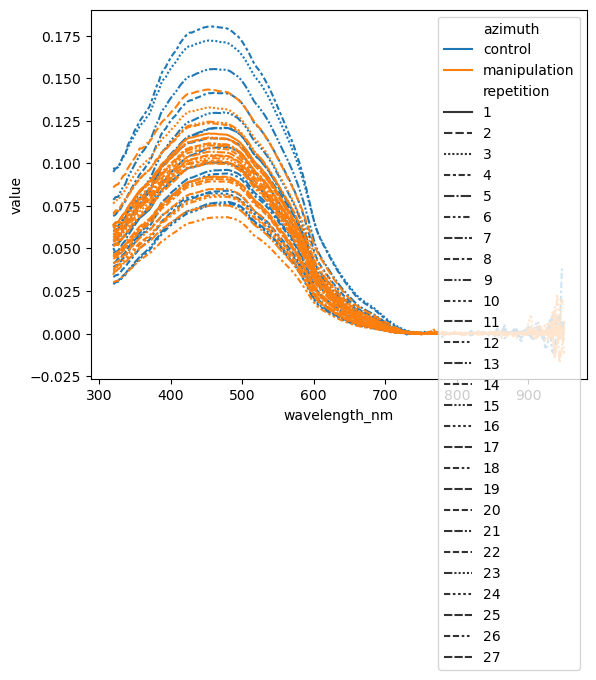

In [293]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Transmittance" & type=="T"'))

<Axes: xlabel='wavelength_nm', ylabel='value'>

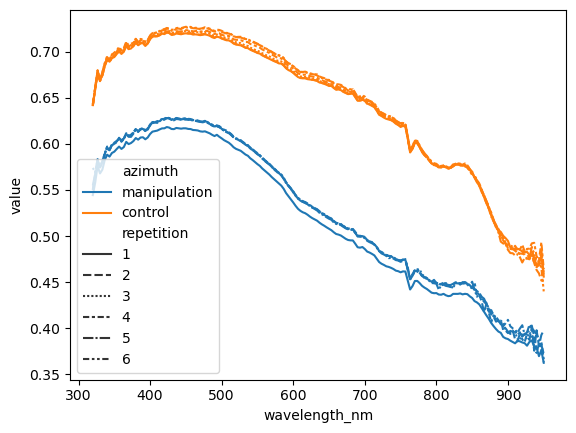

In [294]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Albedo" & type=="A"'))

In [342]:
project_name = '20250715-r2-coring'
df_a1 = convert_00_to_a1(data_path, project_name)

<Axes: xlabel='wavelength_nm', ylabel='value'>

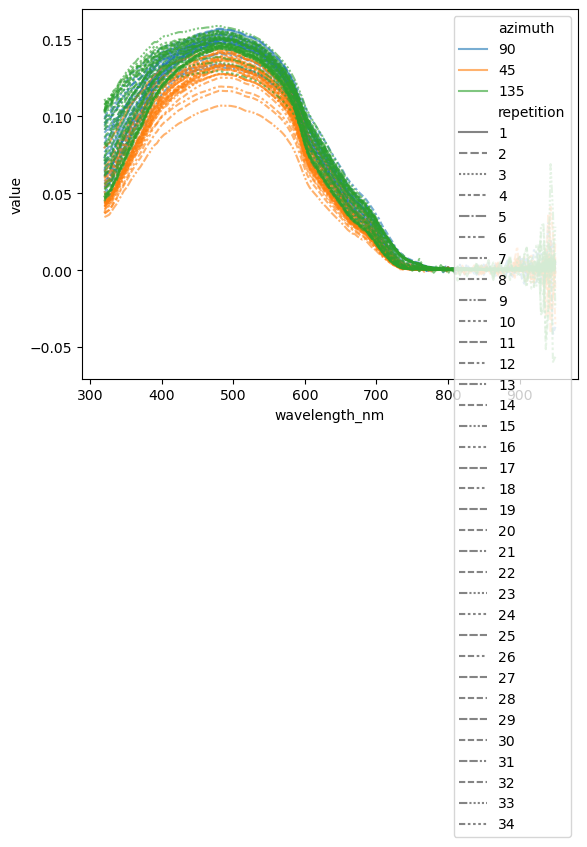

In [343]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Transmittance" & type=="T"'),
            alpha=0.6)

<Axes: xlabel='wavelength_nm', ylabel='value'>

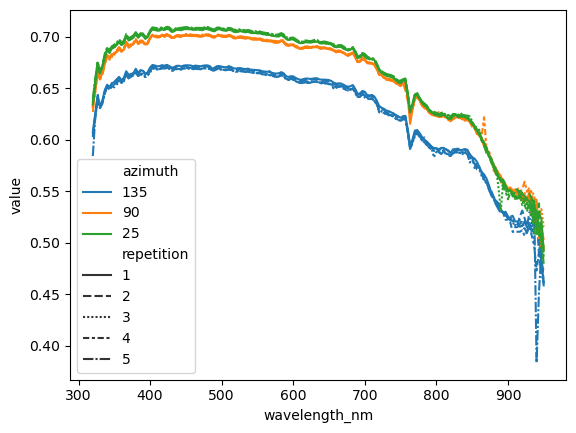

In [344]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Albedo" & type=="A"'))

In [307]:
project_name = '20250715-r2-lead20'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

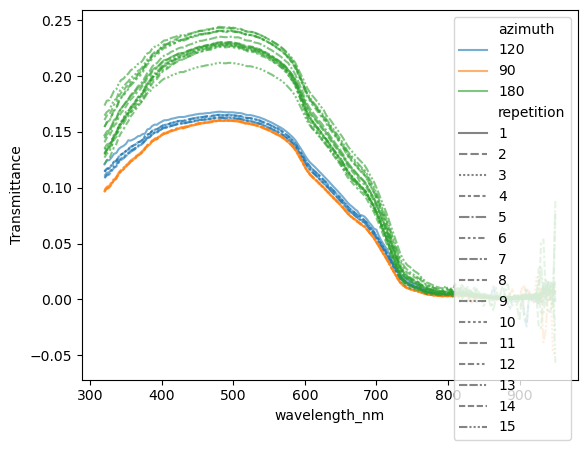

In [308]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

In [303]:
project_name = '20250715-r2-lead5'
df_a1 = convert_00_to_a1(data_path, project_name)

<Axes: xlabel='wavelength_nm', ylabel='value'>

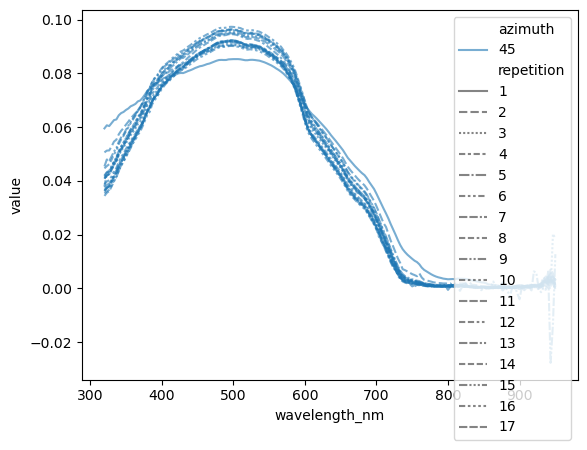

In [304]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)

In [309]:
project_name = '20250716-r2-NEpond'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

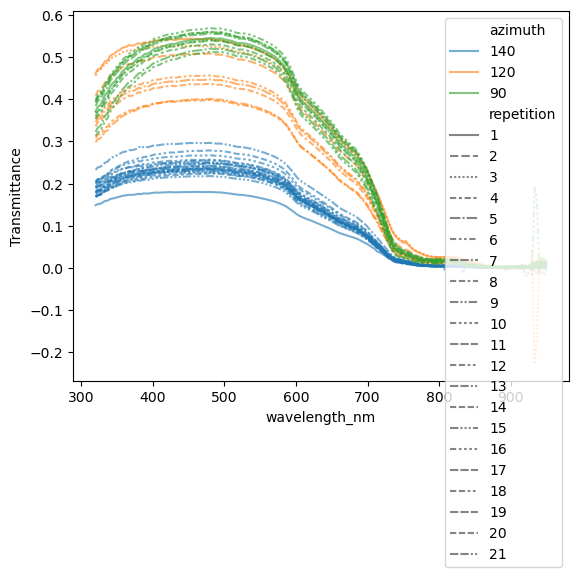

In [310]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

<Axes: xlabel='wavelength_nm', ylabel='value'>

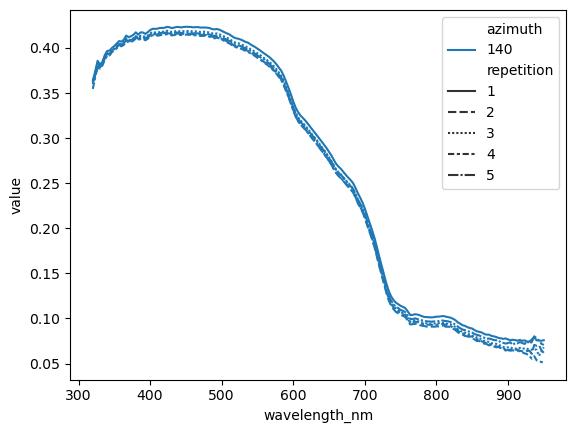

In [311]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Albedo" & type=="A"'))

In [312]:
project_name = '20250716-r2-Spond'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

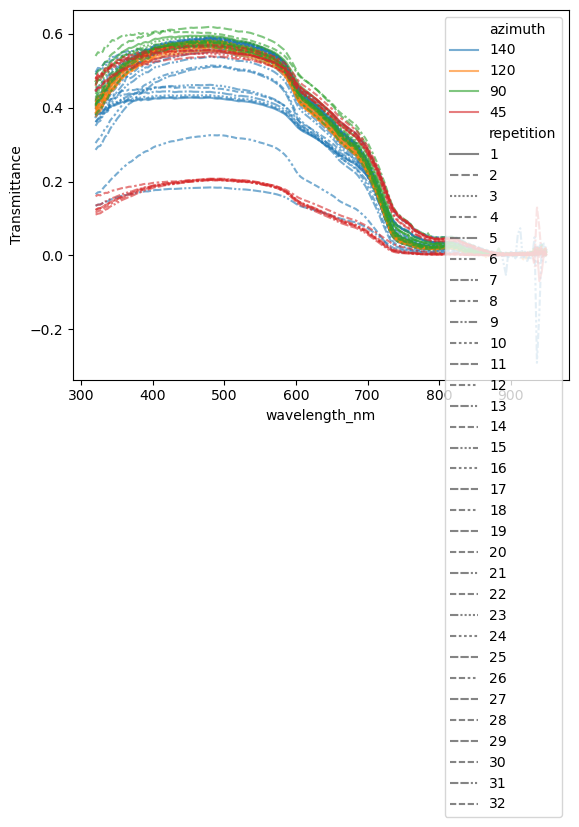

In [313]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Albedo')

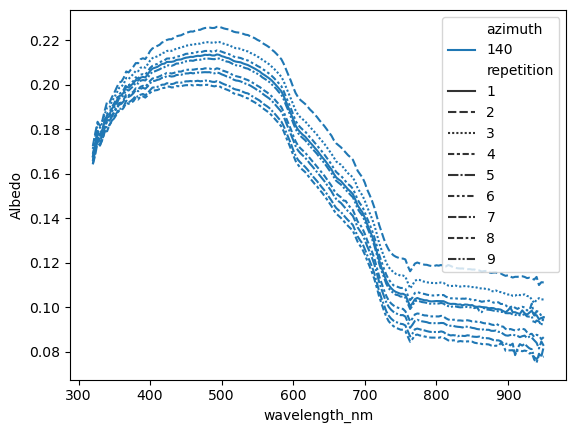

In [314]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [319]:
project_name = '20250716-r2-SNpond'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

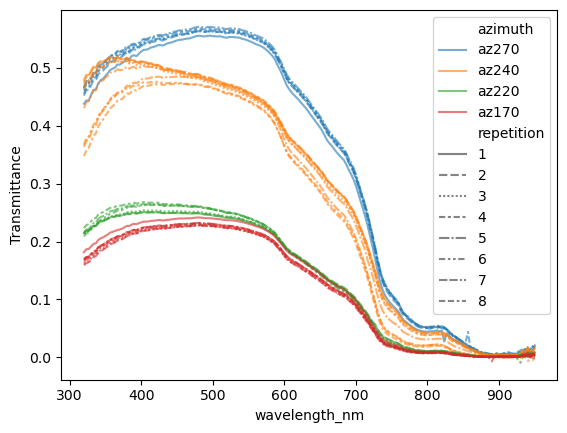

In [320]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Albedo')

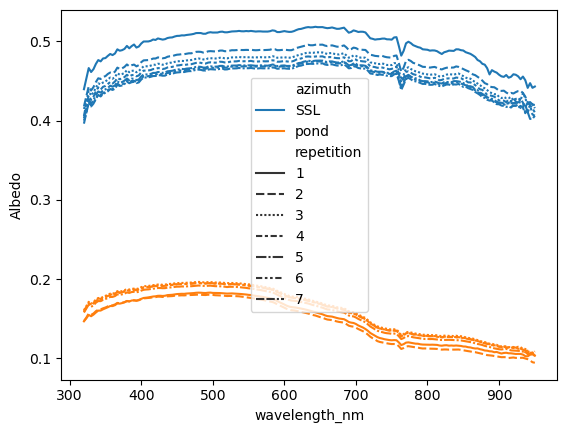

In [321]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [322]:
project_name = '20250716-r2-CKNpond'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

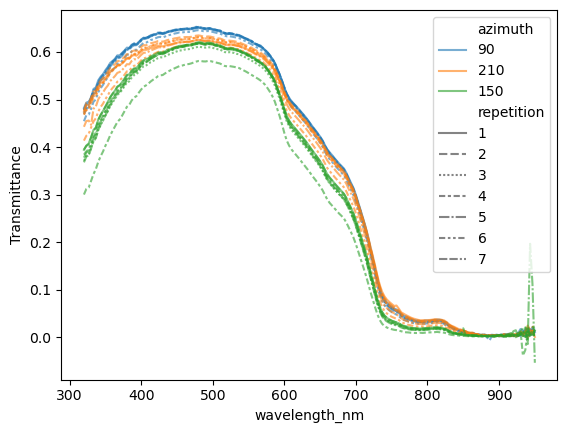

In [323]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Albedo')

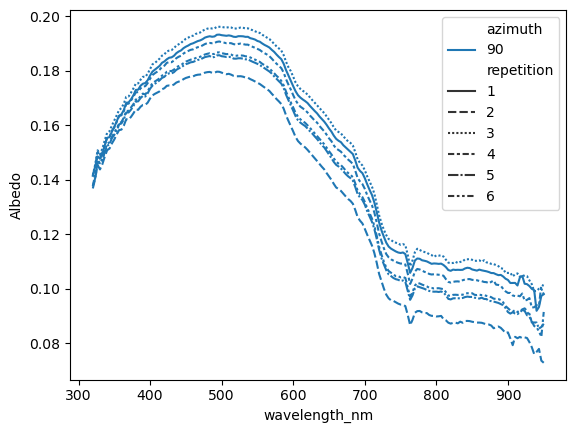

In [324]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [345]:
project_name = '20250720-r3-coring'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

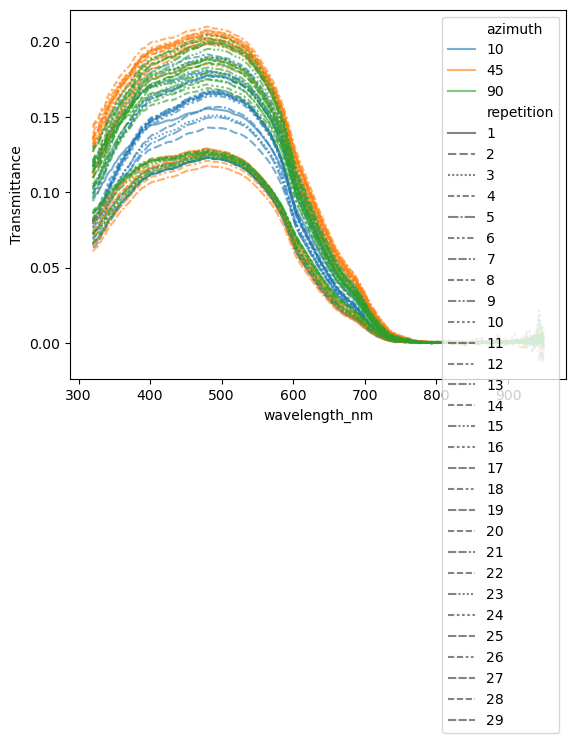

In [346]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Albedo')

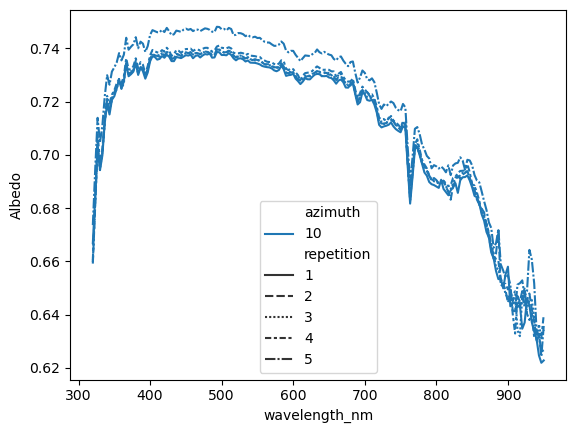

In [347]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [448]:
project_name = '20250720-r3-lead_far'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

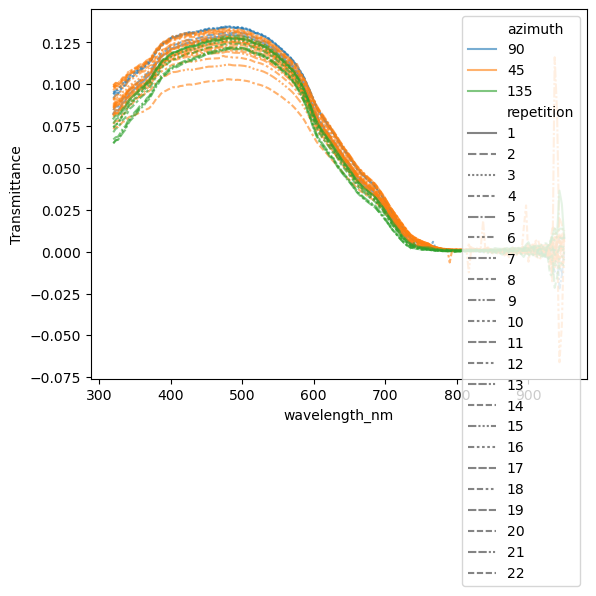

In [449]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

In [451]:
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')
df_temp_2

value
timestamp_utc             station location azimuth type depth repetition wavelength_nm variable           
2025-07-20 14:19:00+00:00 3       lead_far 90      T    NaN   1          NaN           InclV      1.760000
                                                                                       Pressure  -0.001794
2025-07-20 14:19:09+00:00 3       lead_far 90      T    NaN   2          NaN           InclV      2.489408
                                                                                       Pressure   0.014627
2025-07-20 14:19:17+00:00 3       lead_far 90      T    NaN   3          NaN           InclV      3.520000
...                                                                                                    ...
2025-07-20 14:25:05+00:00 3       lead_far 45      T    NaN   20         NaN           Pressure   0.119760
2025-07-20 14:25:12+00:00 3       lead_far 45      T    NaN   21         NaN           InclV     64.315675
                                                                                       Pressure   0.015482
2025-07-20 14:25:18+00:00 3       lead_far 45      T    NaN   22         NaN           InclV     83.139853
                                                                                       Pressure   0.026824

[72 rows x 1 columns]

Text(0, 0.5, 'Albedo')

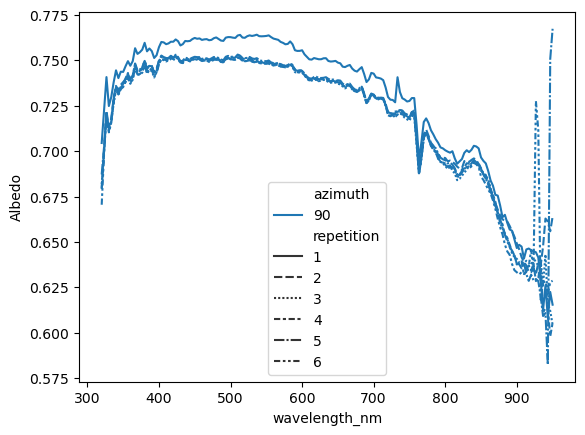

In [333]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [338]:
project_name = '20250720-r3-lead_close'
df_a1 = convert_00_to_a1(data_path, project_name)

RuntimeError: Missing Transmitted or Reflected from ..\data\20250720-r3-lead_close\00\contrasts_4A7F_2025-07-20_14-31-31_493_613_SAM_881D_SPECTRUM_CALIBRATED.dat..\data\20250720-r3-lead_close\00\contrasts_4A7F_2025-07-20_14-31-31_493_610_SAM_881E_SPECTRUM_CALIBRATED.dat

Text(0, 0.5, 'Transmittance')

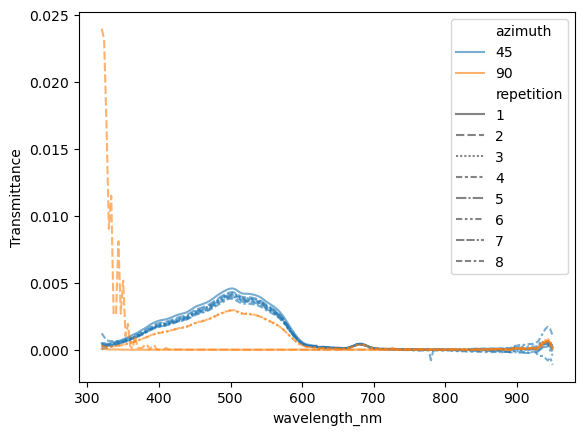

In [335]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Albedo')

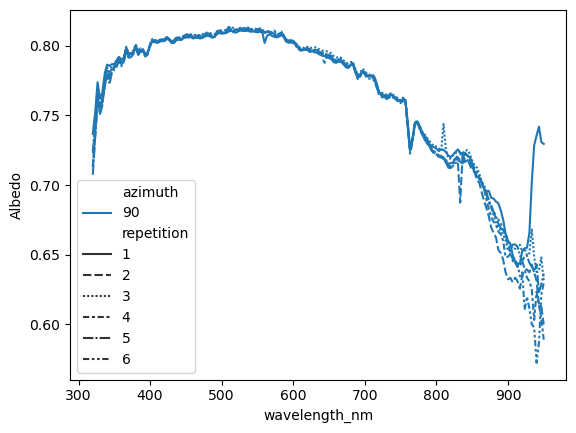

In [336]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [469]:
project_name = '20250726-r1-coring'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

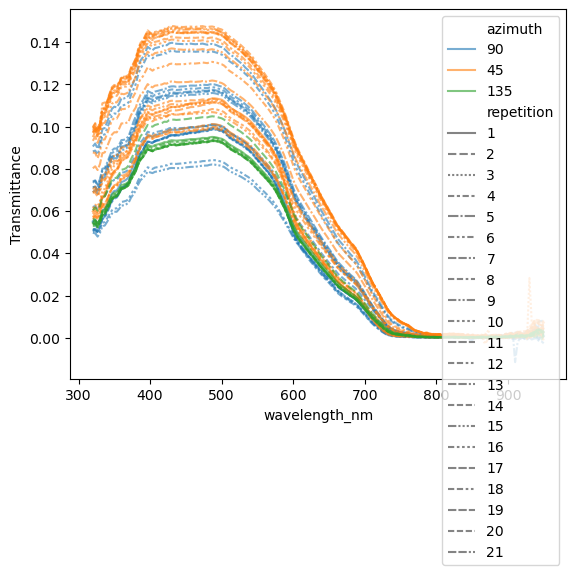

In [470]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Hue Pressure')

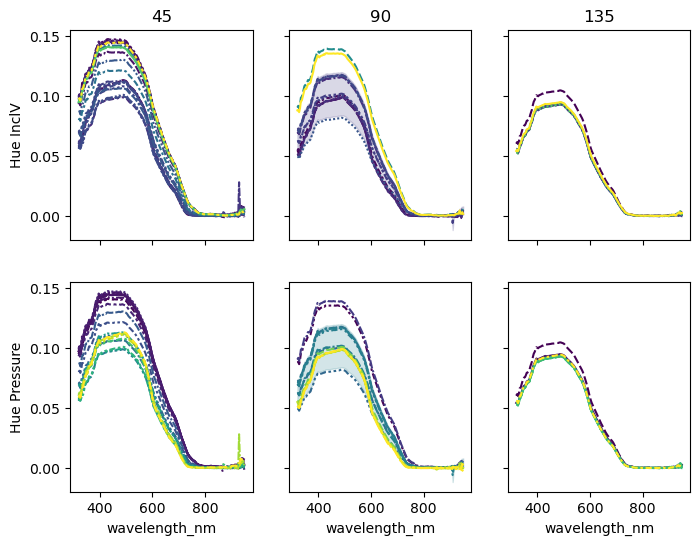

In [482]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')


f, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(8, 6))

az = "45"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,0], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='InclV', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,0], legend=False)
axs[0,0].set_title(az)

az = "90"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,1], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='InclV', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,1], legend=False)
axs[0,1].set_title(az)

az = "135"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,2], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,2], legend=False)
axs[0,2].set_title(az)

axs[0,0].set_ylabel('Hue InclV')
axs[1,0].set_ylabel('Hue Pressure')

Text(0, 0.5, 'Albedo')

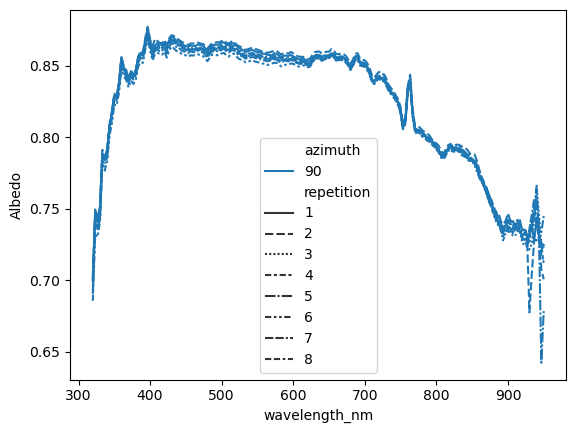

In [463]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [483]:
project_name = '20250726-r1-lead_far'
df_a1 = convert_00_to_a1(data_path, project_name)

(0.0, 0.13)

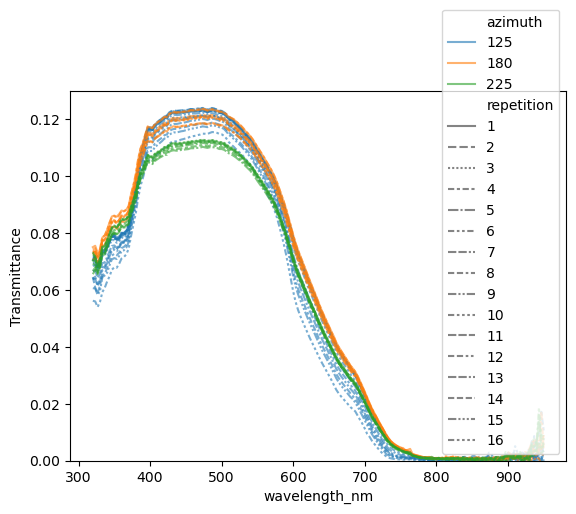

In [486]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')
plt.ylim([0, 0.13])

(0.0, 0.13)

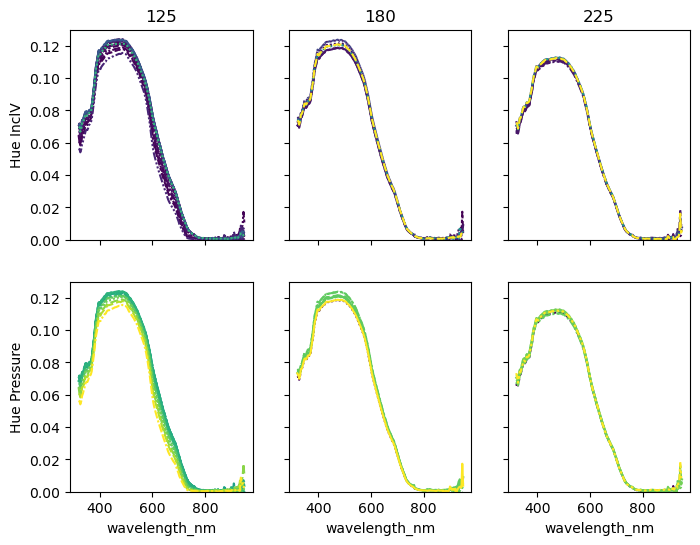

In [488]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')


f, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(8, 6))

az = "125"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,0], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='InclV', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,0], legend=False)
axs[0,0].set_title(az)

az = "180"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,1], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='InclV', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,1], legend=False)
axs[0,1].set_title(az)

az = "225"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,2], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,2], legend=False)
axs[0,2].set_title(az)

axs[0,0].set_ylabel('Hue InclV')
axs[1,0].set_ylabel('Hue Pressure')

axs[0,0].set_ylim([0, 0.13])
axs[1,0].set_ylim([0, 0.13])

Text(0, 0.5, 'Albedo')

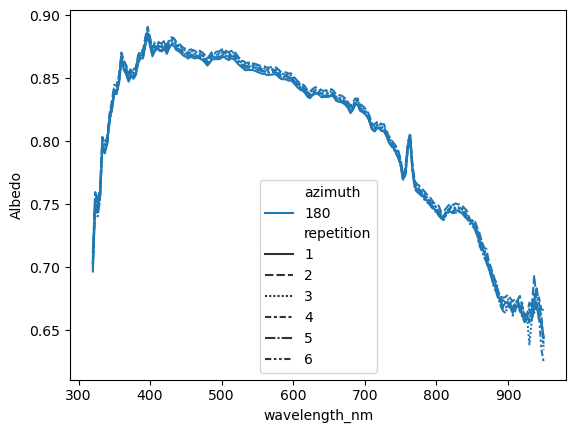

In [489]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [490]:
project_name = '20250726-r1-lead_close'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

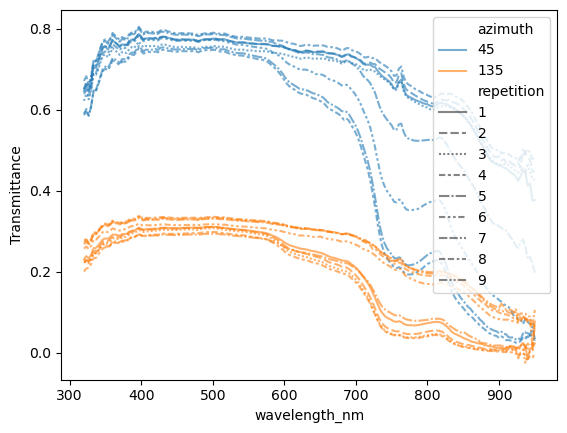

In [491]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')
#plt.ylim([0, 0.13])

Text(0, 0.5, 'Hue Pressure')

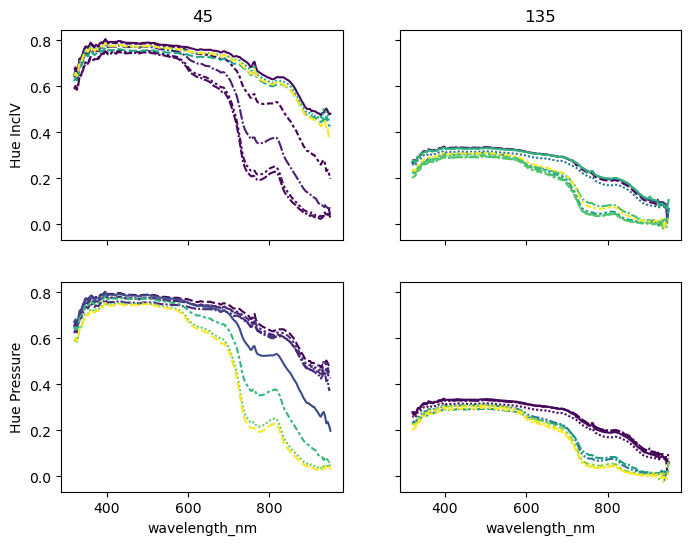

In [492]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')


f, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8, 6))

az = "45"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,0], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='InclV', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,0], legend=False)
axs[0,0].set_title(az)

az = "135"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,1], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='InclV', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,1], legend=False)
axs[0,1].set_title(az)


axs[0,0].set_ylabel('Hue InclV')
axs[1,0].set_ylabel('Hue Pressure')


Text(0, 0.5, 'Albedo')

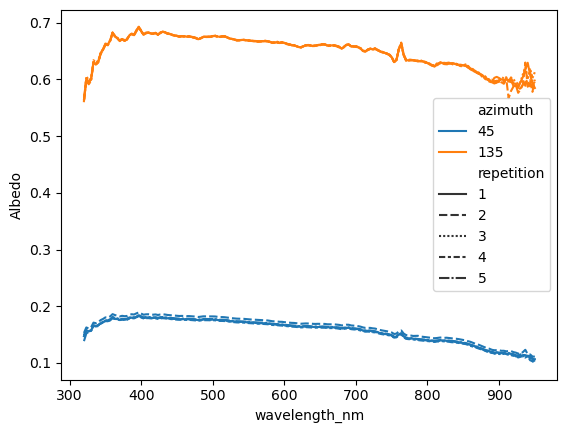

In [493]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Albedo" & type=="A"'))
plt.ylabel('Albedo')

In [494]:
project_name = '20250727-r1-sharedpondeast'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

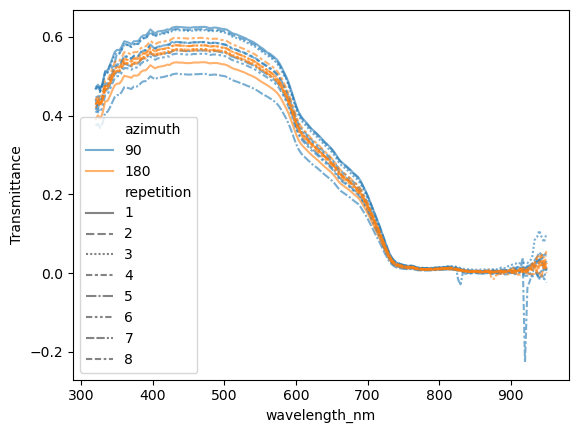

In [495]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')
#plt.ylim([0, 0.13])

Text(0, 0.5, 'Hue Pressure')

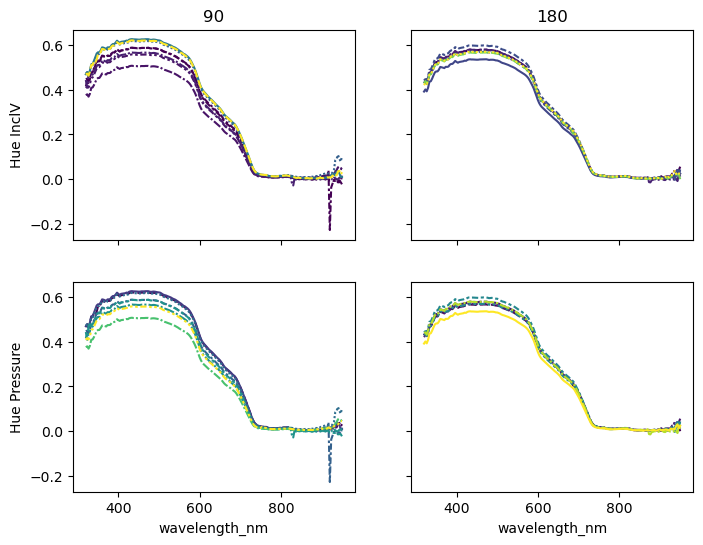

In [497]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')


f, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8, 6))

az = "90"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,0], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,0], legend=False)
axs[0,0].set_title(az)

az = "180"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,1], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,1], legend=False)
axs[0,1].set_title(az)


axs[0,0].set_ylabel('Hue InclV')
axs[1,0].set_ylabel('Hue Pressure')


In [498]:
project_name = '20250727-r1-sharedpondmiddle'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

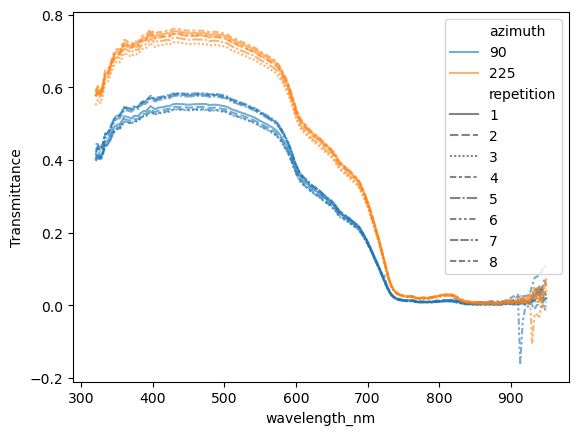

In [499]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Hue Pressure')

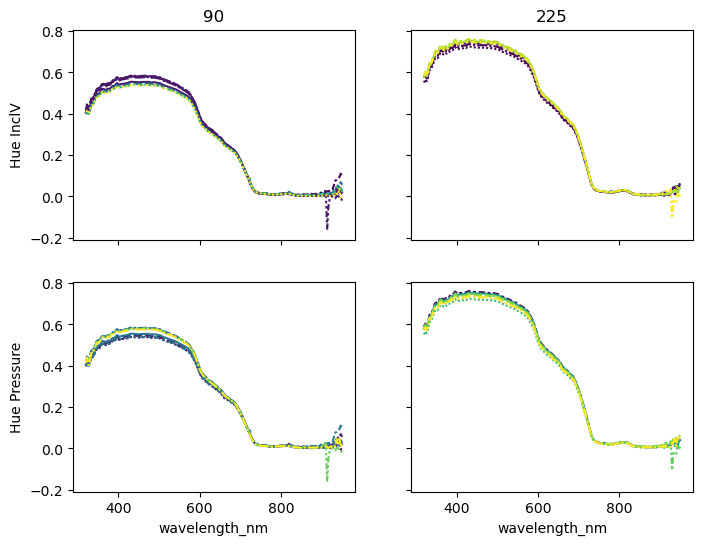

In [500]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')


f, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8, 6))

az = "90"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,0], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,0], legend=False)
axs[0,0].set_title(az)

az = "225"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,1], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,1], legend=False)
axs[0,1].set_title(az)


axs[0,0].set_ylabel('Hue InclV')
axs[1,0].set_ylabel('Hue Pressure')


In [501]:
project_name = '20250727-r1-sharedpondwest'
df_a1 = convert_00_to_a1(data_path, project_name)

Text(0, 0.5, 'Transmittance')

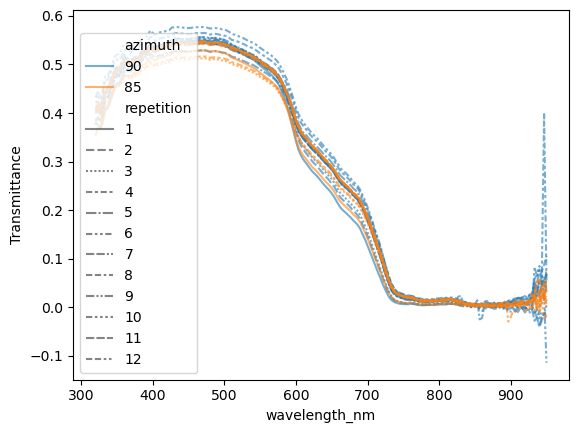

In [502]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), alpha=0.6)
plt.ylabel('Transmittance')

Text(0, 0.5, 'Hue Pressure')

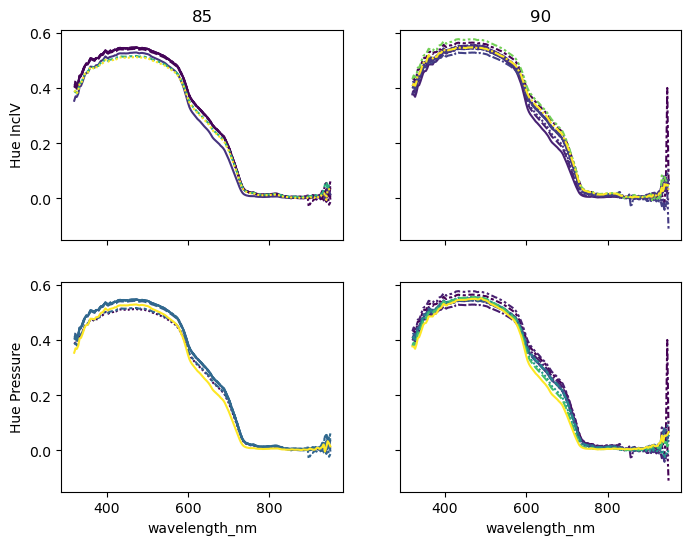

In [503]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')


f, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8, 6))

az = "85"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,0], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,0], legend=False)
axs[0,0].set_title(az)

az = "90"
sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[0,1], legend=False)
sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc', data=df_temp.query('azimuth==@az')
             , palette='viridis', ax=axs[1,1], legend=False)
axs[0,1].set_title(az)


axs[0,0].set_ylabel('Hue InclV')
axs[1,0].set_ylabel('Hue Pressure')


## Plot coring comparison for presentation on July 24

In [350]:
## Load data
data_path = os.path.join('..', 'data')

project_names = ['20250710-r1-coring', '20250715-r2-coring', '20250720-r3-coring']

ls_df_a1 = []
for project_name in project_names:
    ls_df_a1.append(convert_00_to_a1(data_path, project_name))

df_a1 = pd.concat(ls_df_a1)

In [351]:
df_a1

value
timestamp_utc             station location azimuth type depth repetition wavelength_nm variable                        
2025-07-10 11:11:16+00:00 1       coring   0       T    NaN   1          306.306837    Incident_mW/(m^2_nm)         NaN
                                                                         309.632786    Incident_mW/(m^2_nm)         NaN
                                                                         312.959405    Incident_mW/(m^2_nm)         NaN
                                                                         316.286683    Incident_mW/(m^2_nm)         NaN
                                                                         319.614609    Incident_mW/(m^2_nm)  106.798933
...                                                                                                                 ...
2025-07-20 11:09:26+00:00 3       coring   10      T    NaN   25         936.666667    Transmittance_Status    0.000000
                                                                         940.000000    Transmittance_Status    0.000000
                                                                         943.333333    Transmittance_Status    0.000000
                                                                         946.666667    Transmittance_Status    0.000000
                                                                         950.000000    Transmittance_Status    0.000000

[436392 rows x 1 columns]

(0.0, 0.2)

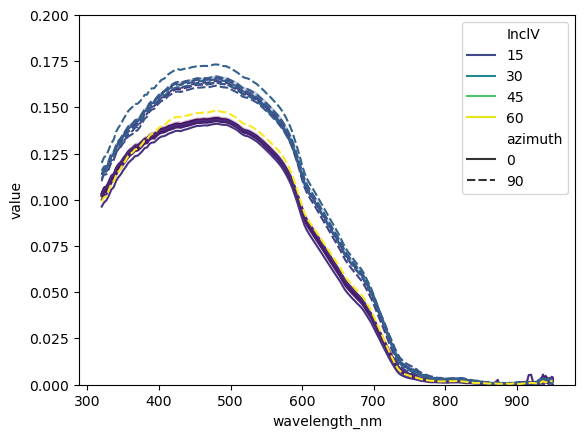

In [447]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('station == "1" & type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('station == "1" & type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')

sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='azimuth', data=df_temp, palette='viridis')
plt.ylim([0, 0.2])

In [ ]:
# for station 1, let's just use all of the physically-meaningful azimuth 0 measurements.

<Axes: xlabel='wavelength_nm', ylabel='value'>

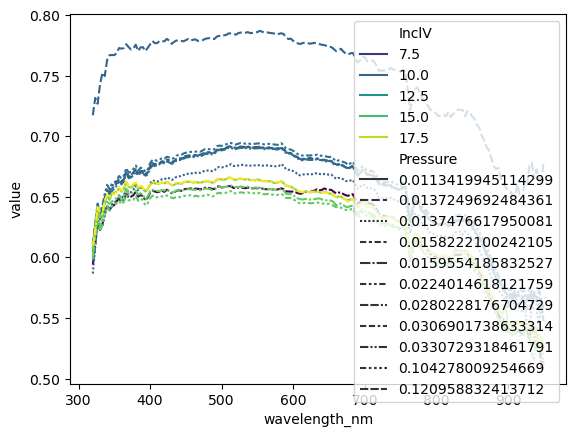

In [418]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('station == "1" & type == "A" & variable == "Albedo"')
df_temp_2 = df_a1.query('station == "1" & type == "A" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')

sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp, palette='viridis')
#plt.ylim([0, 0.2])

In [421]:
# Let's just take the minimum inclination for albedo
df_temp_2.sort_values('InclV')
# "2025-07-10 11:23:25+00:00"

variable             timestamp_utc      InclV  Pressure
1        2025-07-10 11:23:25+00:00   5.567191  0.120959
7        2025-07-10 11:24:15+00:00   8.844587  0.015822
8        2025-07-10 11:24:19+00:00   9.680000  0.030690
6        2025-07-10 11:24:11+00:00   9.720686  0.013748
0        2025-07-10 11:22:33+00:00   9.854375  0.013725
9        2025-07-10 11:24:23+00:00  10.560000  0.033073
10       2025-07-10 11:24:26+00:00  10.597444  0.022401
5        2025-07-10 11:23:58+00:00  15.667077  0.104278
4        2025-07-10 11:23:54+00:00  15.763185  0.015955
2        2025-07-10 11:23:45+00:00  16.289896  0.011342
3        2025-07-10 11:23:50+00:00  18.998459  0.028023

<Axes: xlabel='wavelength_nm', ylabel='value'>

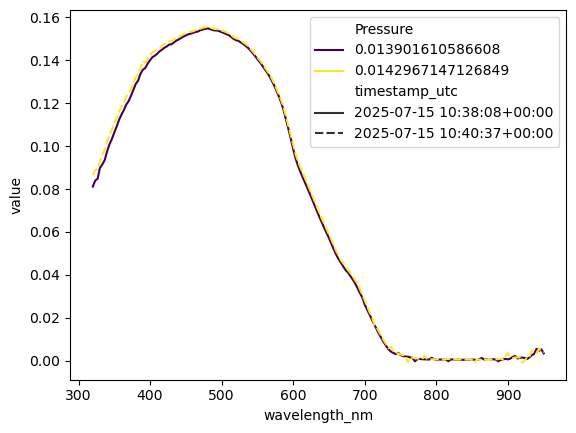

In [406]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
df_temp_1 = df_a1.query('station == "2" & type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('station == "2" & type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')

pressure_quant_thresh = 0.25
pressure_thresh = df_temp_2['Pressure'].quantile(pressure_quant_thresh)

incl_thresh = 16

sns.lineplot(x='wavelength_nm', y='value', hue='Pressure', style='timestamp_utc',#'InclV', 
             data=df_temp.query('Pressure <= @pressure_thresh & InclV <= @incl_thresh'), palette='viridis')
#& azimuth == "135"
#plt.ylim([0, 0.2])

 For station 2, let's use the two scans with some of the lowest combined inclinations and pressures
2025-07-15 10:38:08+00:00
2025-07-15 10:40:37+00:00


<Axes: xlabel='wavelength_nm', ylabel='value'>

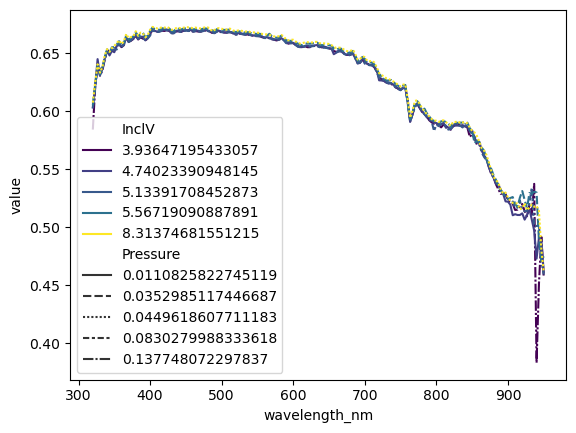

In [428]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
df_temp_1 = df_a1.query('station == "2" & type == "A" & variable == "Albedo"')
df_temp_2 = df_a1.query('station == "2" & type == "A" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')

sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='Pressure', data=df_temp.query('azimuth == "135"'), palette='viridis')
#plt.ylim([0, 0.2])

In [429]:
# For albedo select the minimum inclination with azimuth = 135
df_temp.query('azimuth == "135"').sort_values('InclV')
# "2025-07-15 10:50:40+00:00"

timestamp_utc station location azimuth type  depth  \
949 2025-07-15 10:50:40+00:00       2   coring     135    A    NaN   
827 2025-07-15 10:50:40+00:00       2   coring     135    A    NaN   
826 2025-07-15 10:50:40+00:00       2   coring     135    A    NaN   
825 2025-07-15 10:50:40+00:00       2   coring     135    A    NaN   
824 2025-07-15 10:50:40+00:00       2   coring     135    A    NaN   
..                        ...     ...      ...     ...  ...    ...   
123 2025-07-15 10:50:25+00:00       2   coring     135    A    NaN   
122 2025-07-15 10:50:25+00:00       2   coring     135    A    NaN   
121 2025-07-15 10:50:25+00:00       2   coring     135    A    NaN   
130 2025-07-15 10:50:25+00:00       2   coring     135    A    NaN   
0   2025-07-15 10:50:25+00:00       2   coring     135    A    NaN   

     repetition  wavelength_nm variable     value     InclV  Pressure  
949           5     950.000000   Albedo  0.457487  3.936472  0.137748  
827           5     543.333333   Albedo  0.665203  3.936472  0.137748  
826           5     540.000000   Albedo  0.665229  3.936472  0.137748  
825           5     536.666667   Albedo  0.666128  3.936472  0.137748  
824           5     533.333333   Albedo  0.666021  3.936472  0.137748  
..          ...            ...      ...       ...       ...       ...  
123           1     730.000000   Albedo  0.628309  8.313747  0.044962  
122           1     726.666667   Albedo  0.630048  8.313747  0.044962  
121           1     723.333333   Albedo  0.631123  8.313747  0.044962  
130           1     753.333333   Albedo  0.622855  8.313747  0.044962  
0             1     320.000000   Albedo  0.607394  8.313747  0.044962  

[950 rows x 12 columns]

<Axes: xlabel='wavelength_nm', ylabel='value'>

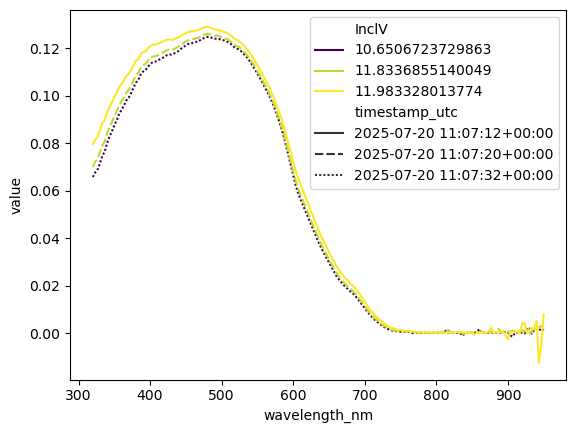

In [412]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
df_temp_1 = df_a1.query('station == "3" & type == "T" & variable == "Transmittance"')
df_temp_2 = df_a1.query('station == "3" & type == "T" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')

pressure_quant_thresh = 0.4
pressure_thresh = df_temp_2['Pressure'].quantile(pressure_quant_thresh)

incl_thresh = 13

sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='timestamp_utc',#'InclV', 
             data=df_temp.query('Pressure <= @pressure_thresh & InclV <= @incl_thresh'), palette='viridis')
#plt.ylim([0, 0.2])

For coring site 3, azimuth 45, the two lowest pressure values are also the two lowest inclination so let's take those.
I worry that azimuth 90 and higher pressure values may have some influence from the snow clearing by the eco coring site.
2025-07-20 11:07:20+00:00
2025-07-20 11:07:32+00:00

<Axes: xlabel='wavelength_nm', ylabel='value'>

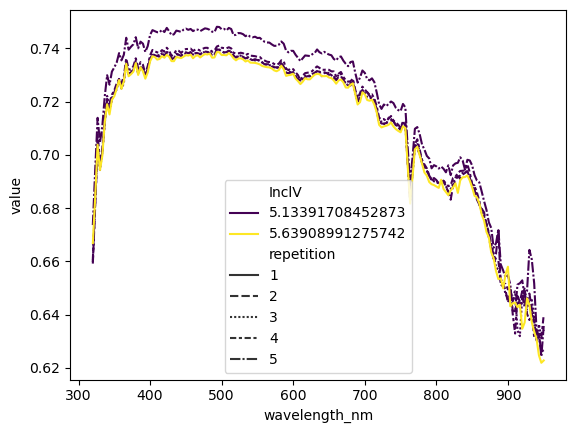

In [432]:
# Need to select single(/averaged?) transmittance and albedo spectra for each site
# Start by looking at r1
df_temp_1 = df_a1.query('station == "3" & type == "A" & variable == "Albedo"')
df_temp_2 = df_a1.query('station == "3" & type == "A" & variable in ["InclV", "Pressure"]')

df_temp_2 = df_temp_2.reset_index().drop(columns=['station', 'location', 'azimuth', 'type', 'depth', 'repetition', 'wavelength_nm'])
df_temp_2 = df_temp_2.pivot(index='timestamp_utc', columns='variable', values='value').reset_index()

df_temp = df_temp_1.reset_index().merge(df_temp_2, left_on='timestamp_utc', right_on='timestamp_utc')

sns.lineplot(x='wavelength_nm', y='value', hue='InclV', style='repetition', data=df_temp, palette='viridis')
#plt.ylim([0, 0.2])

In [ ]:
# The fifth repetition is clearly an outlier, otherwise all of hte spectral look very similar so we can just use the first
# "2025-07-20 10:44:22+00:00"

In [431]:
df_temp

timestamp_utc station location azimuth type  depth  \
0   2025-07-20 10:44:22+00:00       3   coring      10    A    NaN   
1   2025-07-20 10:44:22+00:00       3   coring      10    A    NaN   
2   2025-07-20 10:44:22+00:00       3   coring      10    A    NaN   
3   2025-07-20 10:44:22+00:00       3   coring      10    A    NaN   
4   2025-07-20 10:44:22+00:00       3   coring      10    A    NaN   
..                        ...     ...      ...     ...  ...    ...   
945 2025-07-20 10:44:36+00:00       3   coring      10    A    NaN   
946 2025-07-20 10:44:36+00:00       3   coring      10    A    NaN   
947 2025-07-20 10:44:36+00:00       3   coring      10    A    NaN   
948 2025-07-20 10:44:36+00:00       3   coring      10    A    NaN   
949 2025-07-20 10:44:36+00:00       3   coring      10    A    NaN   

     repetition  wavelength_nm variable     value     InclV  Pressure  
0             1     320.000000   Albedo  0.666836  5.639090 -0.007651  
1             1     323.333333   Albedo  0.684082  5.639090 -0.007651  
2             1     326.666667   Albedo  0.703829  5.639090 -0.007651  
3             1     330.000000   Albedo  0.694253  5.639090 -0.007651  
4             1     333.333333   Albedo  0.699771  5.639090 -0.007651  
..          ...            ...      ...       ...       ...       ...  
945           5     936.666667   Albedo  0.651717  5.133917  0.030693  
946           5     940.000000   Albedo  0.633931  5.133917  0.030693  
947           5     943.333333   Albedo  0.632162  5.133917  0.030693  
948           5     946.666667   Albedo  0.624247  5.133917  0.030693  
949           5     950.000000   Albedo  0.635706  5.133917  0.030693  

[950 rows x 12 columns]

In [434]:
# Selected transmittance measurements:
df_r1_T = df_a1.query('station == "1" & type == "T" & variable == "Transmittance" & azimuth == "0" & value < 0.2')
df_r2_T = df_a1.query('timestamp_utc in ["2025-07-15 10:38:08+00:00", "2025-07-15 10:40:37+00:00"] & variable == "Transmittance"')
df_r3_T = df_a1.query('timestamp_utc in ["2025-07-20 11:07:20+00:00", "2025-07-20 11:07:32+00:00"] & variable == "Transmittance"')

alb_ts = ["2025-07-10 11:23:25+00:00", "2025-07-15 10:50:40+00:00", "2025-07-20 10:44:22+00:00"]
df_A = df_a1.query('variable == "Albedo" & timestamp_utc in @alb_ts')

df_sel = pd.concat([df_r1_T, df_r2_T, df_r3_T, df_A])

In [438]:
df_sel

value
timestamp_utc             station location azimuth type depth repetition wavelength_nm variable               
2025-07-10 11:15:39+00:00 1       coring   0       T    NaN   2          320.000000    Transmittance  0.102360
                                                                         323.333333    Transmittance  0.106016
                                                                         326.666667    Transmittance  0.106509
                                                                         330.000000    Transmittance  0.109334
                                                                         333.333333    Transmittance  0.112519
...                                                                                                        ...
2025-07-20 10:44:22+00:00 3       coring   10      A    NaN   1          936.666667    Albedo         0.633628
                                                                         940.000000    Albedo         0.630747
                                                                         943.333333    Albedo         0.624624
                                                                         946.666667    Albedo         0.621874
                                                                         950.000000    Albedo         0.622747

[3990 rows x 1 columns]

In [441]:
df_site = df_sel.reset_index()[['station', 'wavelength_nm', 'variable', 'value']
                              ].groupby(['station', 'wavelength_nm', 'variable']).mean()

df_site = df_site.reset_index().pivot(index=['station', 'wavelength_nm'], columns='variable', values='value')
df_site['Absorption'] = 1 - df_site['Albedo'] - df_site['Transmittance']

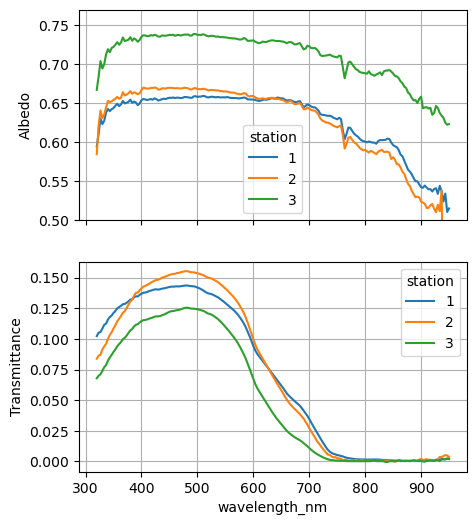

In [446]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 6))

sns.lineplot(x='wavelength_nm', y='Albedo', hue='station', 
             data=df_site, ax=axs[0])
axs[0].set_ylabel('Albedo')
axs[0].grid()
axs[0].set_ylim([0.5, 0.77])

#sns.lineplot(x='wavelength_nm', y='Absorption', hue='station', 
#             data=df_site, ax=axs[1])
#axs[1].set_ylabel('Absorption')
#axs[1].grid()

sns.lineplot(x='wavelength_nm', y='Transmittance', hue='station', 
             data=df_site, ax=axs[1])
axs[1].set_ylabel('Transmittance')
axs[1].grid()

f.savefig(os.path.join('..', 'figures', 'coring_site_comparison.png'), bbox_inches='tight')

<Axes: xlabel='wavelength_nm', ylabel='value'>

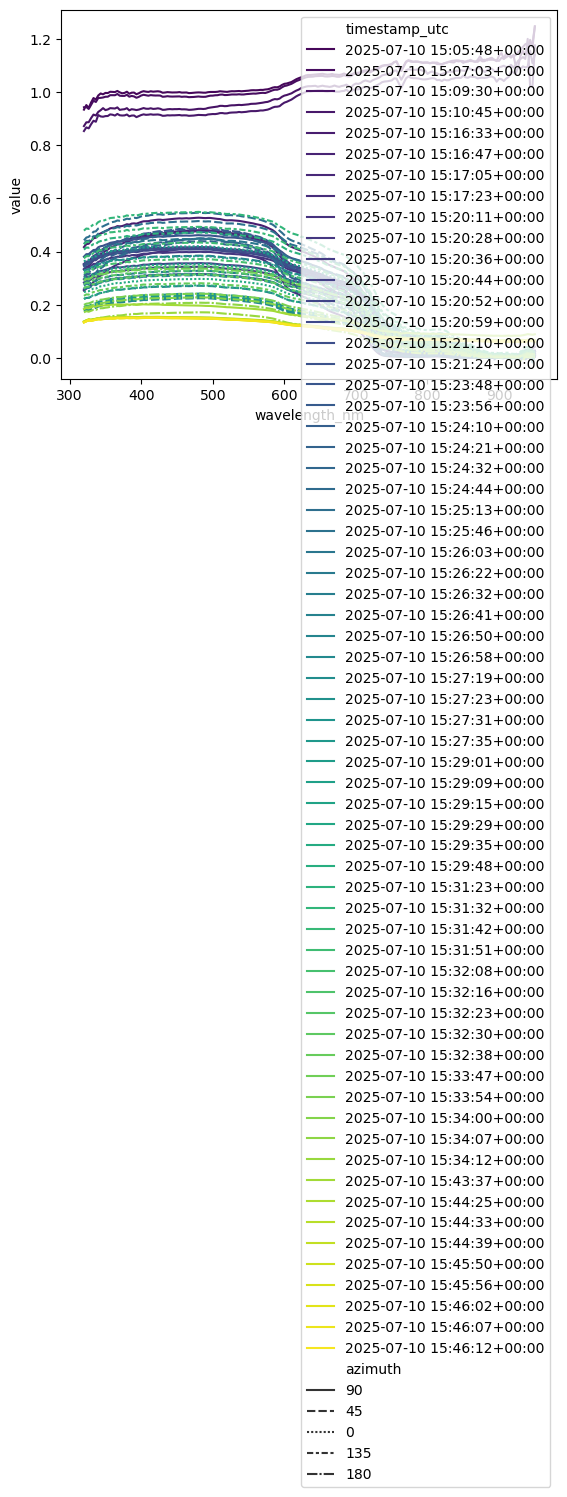

In [281]:
sns.lineplot(x='wavelength_nm', y='value', hue='timestamp_utc', style='azimuth', 
             data=df_a1.query('variable=="Transmittance" & type=="T"'), palette='viridis')

In [225]:
# paths
data_path = os.path.join('..', 'data')
project_name = '20250716-r2-Spond'
data_level = '00'

In [121]:
filename = 'contrasts_4A7F_2025-07-16_14-24-01_448_111_SAM_881D_SPECTRUM_CALIBRATED.dat'
df_881D = read_spectrum_file(os.path.join(data_path, project_name, data_level, filename))

filename = 'contrasts_4A7F_2025-07-16_14-24-01_448_115_SAM_881E_SPECTRUM_CALIBRATED.dat'
df_881E = read_spectrum_file(os.path.join(data_path, project_name, data_level, filename))

In [252]:
# Read in all measurements from a location

# Identify measurement pairs
ls_filenames = os.listdir(os.path.join(data_path, project_name, data_level))
ls_lonely = []
ls_pairs = []
for filename in ls_filenames:
    if re.search('SPECTRUM_CALIBRATED', filename):
        lonely = True
        for i in range(len(ls_lonely)):
            other_filename = ls_lonely[i]
            if filename[:38]==other_filename[:38]:
                ls_pairs.append((os.path.join(data_path, project_name, data_level, filename),
                                 os.path.join(data_path, project_name, data_level, ls_lonely.pop(i))))
                lonely = False
                break
        if lonely:
            ls_lonely.append(filename)

# Load each dataset and set the repetition correctly
ls_df = []
for i in range(len(ls_pairs)):
    ls_df.append(read_paired_spectra(ls_pairs[i]))
    
    # On the first one just copy the multiindex.
    if i == 0:
        ls_df[i].index = ls_df[i].index.set_levels(np.ones(ls_df[i].size, dtype=np.int64), level='repetition',
                                                  verify_integrity=False)
        ind = ls_df[i].index.droplevel(['timestamp_utc', 'wavelength_nm', 'variable']).unique()
    else:
        # Check if we have prior repetitions at this site
        new_ind = ls_df[i].index.droplevel(['timestamp_utc', 'wavelength_nm', 'variable', 'repetition']).unique()
        ind_mask = ind.droplevel('repetition').isin(new_ind) # boolean array of matching indices
        if ind_mask.any():
            rep = ind[ind_mask].get_level_values('repetition').max() + 1
        else:
            rep = 1
        # Update repetition values in new dataframe
        ls_df[i].index = ls_df[i].index.set_levels(rep*np.ones(ls_df[i].size, dtype=np.int64), level='repetition',
                                                  verify_integrity=False)
        # Add the new index to ind
        ind = ind.append(ls_df[i].index.droplevel(['timestamp_utc', 'wavelength_nm', 'variable']).unique())
        break

df_a1 = pd.concat(ls_df)

In [255]:
df_test = pd.concat([df_a1, None])

In [254]:
df_a1

value
timestamp_utc             station location azimuth type depth repetition wavelength_nm variable                      
2025-07-16 14:24:01+00:00 2       Spond    140     A    NaN   1          306.306837    Incident_mW/(m^2_nm)       NaN
                                                                         309.632786    Incident_mW/(m^2_nm)       NaN
                                                                         312.959405    Incident_mW/(m^2_nm)       NaN
                                                                         316.286683    Incident_mW/(m^2_nm)       NaN
                                                                         319.614609    Incident_mW/(m^2_nm)  95.15915
...                                                                                                               ...
2025-07-16 14:24:10+00:00 2       Spond    140     A    NaN   2          936.666667    Albedo_Status          0.00000
                                                                         940.000000    Albedo_Status          0.00000
                                                                         943.333333    Albedo_Status          0.00000
                                                                         946.666667    Albedo_Status          0.00000
                                                                         950.000000    Albedo_Status          0.00000

[3828 rows x 1 columns]

In [243]:
ind

MultiIndex([('2', 'Spond', '140', 'A', nan,  1),
            ('2', 'Spond', '140', 'A', nan,  2),
            ('2', 'Spond', '140', 'A', nan,  3),
            ('2', 'Spond', '140', 'A', nan,  4),
            ('2', 'Spond', '140', 'A', nan,  5),
            ('2', 'Spond', '140', 'A', nan,  6),
            ('2', 'Spond', '140', 'A', nan,  7),
            ('2', 'Spond', '140', 'A', nan,  8),
            ('2', 'Spond', '140', 'A', nan,  9),
            ('2', 'Spond', '140', 'T', nan,  1),
            ('2', 'Spond', '140', 'T', nan,  2),
            ('2', 'Spond', '140', 'T', nan,  3),
            ('2', 'Spond', '140', 'T', nan,  4),
            ('2', 'Spond', '140', 'T', nan,  5),
            ('2', 'Spond', '140', 'T', nan,  6),
            ('2', 'Spond', '140', 'T', nan,  7),
            ('2', 'Spond', '140', 'T', nan,  8),
            ('2', 'Spond', '140', 'T', nan,  9),
            ('2', 'Spond', '140', 'T', nan, 10),
            ('2', 'Spond', '140', 'T', nan, 11),
            ('2', 'S

<Axes: xlabel='wavelength_nm', ylabel='value'>

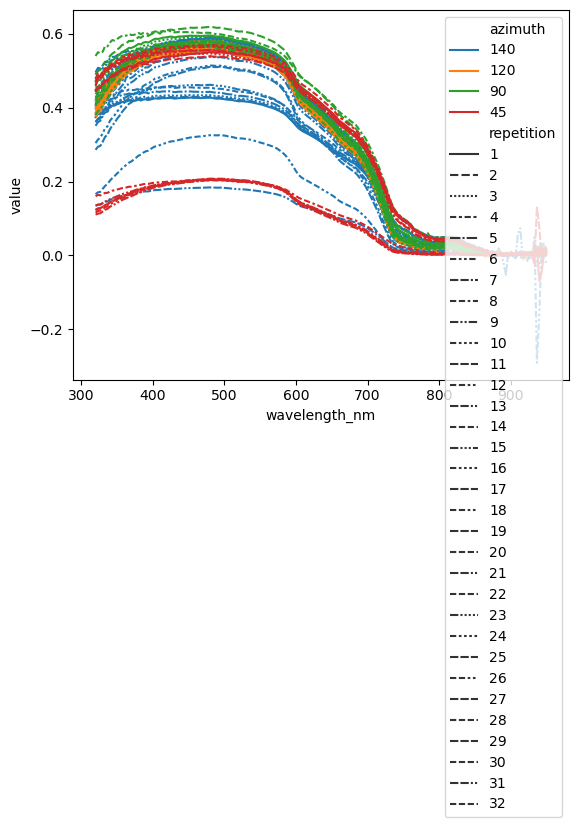

In [244]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Transmittance" & type=="T"'))

In [168]:
sns.lineplot(x='wavelength_nm', y='value', hue='azimuth', style='repetition', data=df_a1.query('variable=="Transmittance"'))

In [216]:

df_temp = pd.concat([
    df_a1.query('azimuth == "45" & wavelength_nm == 500 & variable == "Transmittance"'),
    df_a1.query('azimuth == "45" & variable == "Pressure"'),
    df_a1.query('azimuth == "45" & variable in ["InclV", "InclX", "InclY"]'),
    ])

df_temp.index = df_temp.index.droplevel(['wavelength_nm', 'repetition'])
#df_temp
df_temp.reset_index().pivot(index='timestamp_utc', columns='variable', values='value')

variable                       InclV  InclX  InclY  Pressure  Transmittance
timestamp_utc                                                              
2025-07-16 15:02:46+00:00  10.284138  -8.80  -5.28  0.012812       0.548533
2025-07-16 15:02:52+00:00   9.537535  -7.92  -5.28 -0.001310       0.536825
2025-07-16 15:03:00+00:00  12.261207 -10.56  -6.16  0.091323       0.542484
2025-07-16 15:03:06+00:00  12.629729 -11.44  -5.28  0.020222       0.567549
2025-07-16 15:03:10+00:00  12.629729 -11.44  -5.28  0.001068       0.552530
2025-07-16 15:03:17+00:00  12.736716 -10.56  -7.04 -0.001880       0.562242
2025-07-16 15:03:25+00:00  12.736716 -10.56  -7.04  0.010292       0.552961
2025-07-16 15:03:49+00:00  20.270557 -12.32 -15.84  0.038861       0.204678
2025-07-16 15:04:03+00:00  13.139744  -8.80  -9.68  0.098387       0.203060
2025-07-16 15:04:07+00:00  12.495013  -8.80  -8.80  0.062773       0.202557
2025-07-16 15:04:12+00:00  12.495013  -8.80  -8.80  0.008338       0.207168
2025-07-16 15:04:17+00:00  12.495013  -8.80  -8.80  0.048385       0.205848
2025-07-16 15:04:20+00:00  14.244887 -12.32  -7.04  0.112735       0.204262

<Axes: xlabel='wavelength_nm', ylabel='value'>

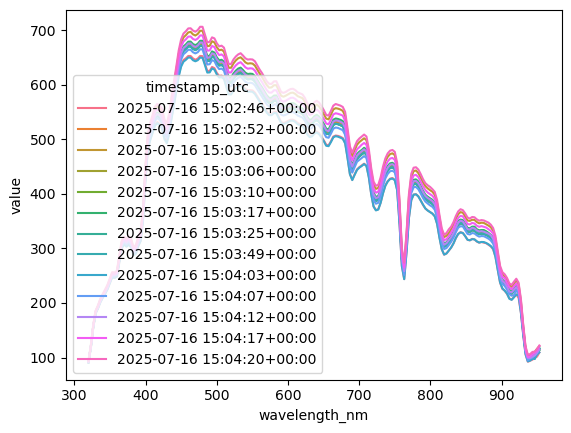

In [217]:
sns.lineplot(x='wavelength_nm', y='value', hue='timestamp_utc', 
             data=df_a1.query('azimuth == "45" & variable == "Incident_mW/(m^2_nm)"'))

<Axes: xlabel='wavelength_nm', ylabel='value'>

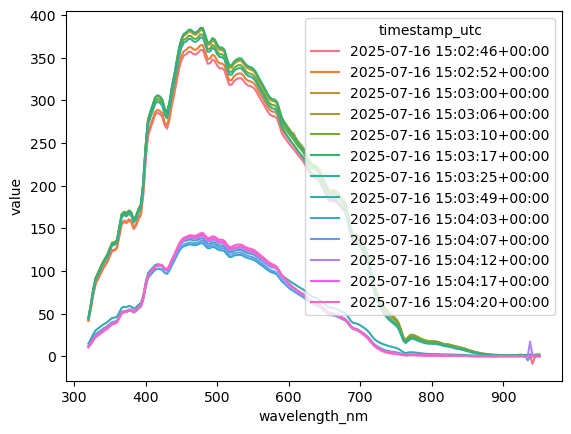

In [218]:
sns.lineplot(x='wavelength_nm', y='value', hue='timestamp_utc', 
             data=df_a1.query('azimuth == "45" & variable == "Transmitted_mW/(m^2_nm)"'))

In [221]:

df_temp = pd.concat([
    df_a1.query('azimuth == "140" & wavelength_nm == 500 & variable == "Transmittance"'),
    df_a1.query('azimuth == "140" & variable == "Pressure"'),
    df_a1.query('azimuth == "140" & variable in ["InclV", "InclX", "InclY"]'),
    ])

df_temp.index = df_temp.index.droplevel(['wavelength_nm', 'repetition'])
#df_temp
df_temp = df_temp.reset_index().pivot(index='timestamp_utc', columns='variable', values='value')
df_temp

variable                       InclV  InclX  InclY  Pressure  Transmittance
timestamp_utc                                                              
2025-07-16 14:24:01+00:00   9.680000   0.00   9.68 -0.007300            NaN
2025-07-16 14:24:10+00:00   9.680000   0.00   9.68 -0.007172            NaN
2025-07-16 14:24:16+00:00  10.597444  -0.88  10.56  0.005068            NaN
2025-07-16 14:24:24+00:00   9.720686   0.88   9.68  0.016735            NaN
2025-07-16 14:24:28+00:00   9.720686   0.88   9.68  0.007172            NaN
2025-07-16 14:24:33+00:00   7.969363   0.88   7.92  0.045589            NaN
2025-07-16 14:24:37+00:00   7.969363   0.88   7.92 -0.008034            NaN
2025-07-16 14:24:40+00:00   7.969363   0.88   7.92 -0.007587            NaN
2025-07-16 14:24:43+00:00   8.844587   0.88   8.80  0.019126            NaN
2025-07-16 14:55:54+00:00  44.385861 -33.44  25.52  0.031845       0.422891
2025-07-16 14:56:10+00:00  44.385861 -33.44  25.52  0.036603       0.425465
2025-07-16 14:56:15+00:00  44.385861 -33.44  25.52 -0.001178       0.429682
2025-07-16 14:56:22+00:00  44.274607 -32.56  26.40  0.022045       0.449452
2025-07-16 14:56:33+00:00  44.875128 -30.80  29.04  0.017570       0.438181
2025-07-16 14:56:38+00:00  58.455838 -26.40 -46.64  0.017570       0.550740
2025-07-16 14:56:41+00:00  54.873753 -22.00 -46.64  0.003295       0.557603
2025-07-16 14:56:44+00:00  35.432651 -18.48 -29.04 -0.004414       0.565439
2025-07-16 14:56:48+00:00  31.582636 -18.48 -24.64  0.010432       0.534843
2025-07-16 14:56:52+00:00  36.424546 -21.12 -28.16  0.027086       0.512124
2025-07-16 14:56:56+00:00  41.800759 -16.72 -36.96  0.008053       0.509460
2025-07-16 14:56:59+00:00  26.311454 -14.96 -21.12  0.001201       0.572438
2025-07-16 14:57:05+00:00  24.279623 -14.08 -19.36  0.036603       0.577084
2025-07-16 14:57:09+00:00  22.835476 -14.08 -17.60  0.008053       0.583631
2025-07-16 14:57:13+00:00  22.258603 -10.56 -19.36  0.001201       0.578559
2025-07-16 14:57:16+00:00  33.037249 -15.84 -28.16  0.079149       0.554990
2025-07-16 14:57:20+00:00  27.091764 -10.56 -24.64  0.119873       0.578881
2025-07-16 14:57:23+00:00  22.258603 -10.56 -19.36  0.019939       0.580348
2025-07-16 14:57:28+00:00  31.258570 -14.08 -27.28 -0.004128       0.548780
2025-07-16 14:57:32+00:00  24.756303 -12.32 -21.12  0.006074       0.577825
2025-07-16 14:57:36+00:00  23.218278 -12.32 -19.36  0.036603       0.584473
2025-07-16 14:57:39+00:00  23.218278 -12.32 -19.36  0.067532       0.582630
2025-07-16 14:57:43+00:00  23.551262 -14.08 -18.48  0.008053       0.587802
2025-07-16 14:57:46+00:00  24.756303 -12.32 -21.12  0.024972       0.586394
2025-07-16 14:57:54+00:00  23.551262 -14.08 -18.48 -0.004414       0.585702
2025-07-16 14:57:56+00:00  23.218278 -12.32 -19.36  0.041361       0.582241
2025-07-16 15:05:52+00:00  28.894431 -27.28   8.80  0.083993       0.182898
2025-07-16 15:05:59+00:00  32.069572 -14.08 -28.16  0.001201       0.564540
2025-07-16 15:06:04+00:00  16.336085 -12.32 -10.56  0.105390       0.572069
2025-07-16 15:06:21+00:00  39.560991 -31.68  21.12  0.015191       0.324312
2025-07-16 15:06:36+00:00  73.541602 -25.52 -58.96  0.046004       0.457376
2025-07-16 15:06:46+00:00  12.495013  -8.80  -8.80  0.098257       0.567577

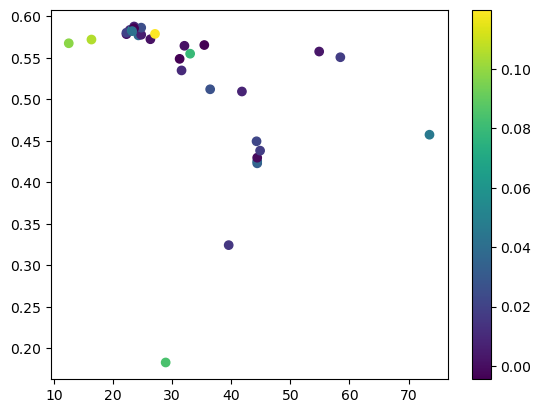

In [224]:
plt.scatter('InclV', 'Transmittance', c='Pressure', data=df_temp)
plt.colorbar()

<Axes: xlabel='wavelength_nm', ylabel='value'>

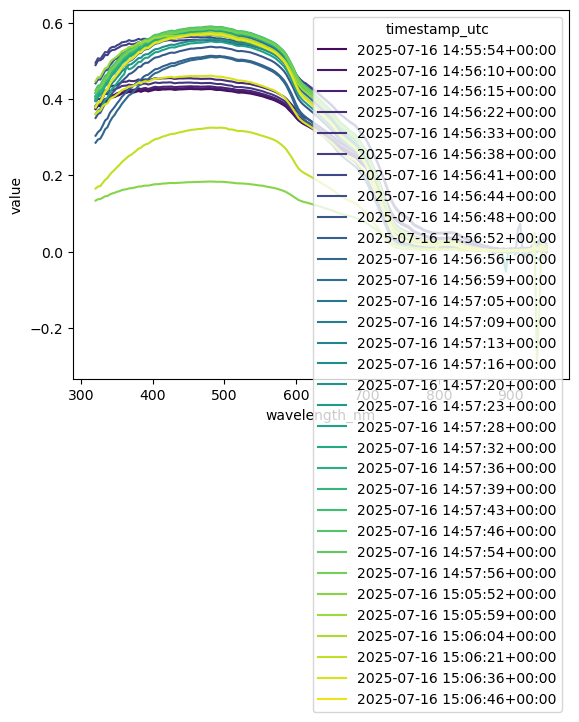

In [246]:
sns.lineplot(x='wavelength_nm', y='value', hue='timestamp_utc', palette='viridis',
             data=df_a1.query('azimuth == "140" & variable == "Transmittance"'))

In [174]:
df_out.index.droplevel(['repetition', 'wavelength_nm', 'variable']).unique()

MultiIndex([('2025-07-16 14:24:01+00:00', '2', 'Spond', '140', nan)],
           names=['timestamp_utc', 'station', 'location', 'azimuth', 'depth'])

In [175]:
ind = pd.MultiIndex()

TypeError: Must pass both levels and codes

<Axes: xlabel='timestamp_utc,station,location,azimuth,depth,repetition,wavelength_nm,variable'>

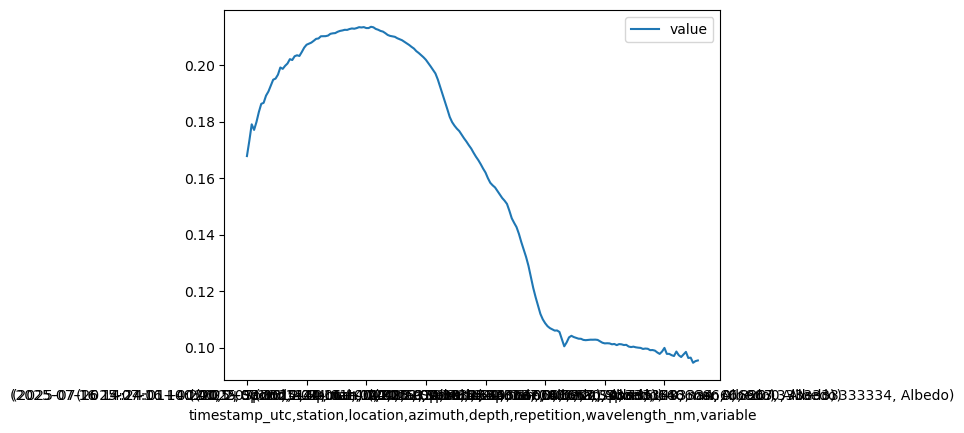

In [170]:
df_out.query('variable == "Albedo"').plot()

In [171]:
df_out

value
timestamp_utc             station location azimuth depth repetition wavelength_nm variable                      
2025-07-16 14:24:01+00:00 2       Spond    140     NaN   0          306.306837    Incident_mW/(m^2_nm)       NaN
                                                                    309.632786    Incident_mW/(m^2_nm)       NaN
                                                                    312.959405    Incident_mW/(m^2_nm)       NaN
                                                                    316.286683    Incident_mW/(m^2_nm)       NaN
                                                                    319.614609    Incident_mW/(m^2_nm)  95.15915
...                                                                                                          ...
                                                                    936.666667    Albedo_Status          0.00000
                                                                    940.000000    Albedo_Status          0.00000
                                                                    943.333333    Albedo_Status          0.00000
                                                                    946.666667    Albedo_Status          0.00000
                                                                    950.000000    Albedo_Status          0.00000

[1914 rows x 1 columns]

In [123]:
# Read in paired spectra
fn_1, fn_2 = ls_pairs[0]
df_1 = read_spectrum_file(os.path.join(data_path, project_name, data_level, fn_1))
df_2 = read_spectrum_file(os.path.join(data_path, project_name, data_level, fn_2))

In [162]:
# Read in paired spectra
fn_1, fn_2 = ls_pairs[0]
df_1 = read_spectrum_file(os.path.join(data_path, project_name, data_level, fn_1))
df_2 = read_spectrum_file(os.path.join(data_path, project_name, data_level, fn_2))

# The instruments don't actually measure exactly the same wavelengths... so we need to interpolate
var_list = ["Incident_mW/(m^2_nm)", "Reflected_mW/(m^2_nm)", "Transmitted_mW/(m^2_nm)",
           "Incident_Status", "Reflected_Status", "Transmitted_Status"]
wvs_interp = np.linspace(320, 950, 190)
merge_dict = {}

df_temp_1 = df_1.query('variable in @var_list & @notna_var(value)').reset_index(level='variable').pivot(columns='variable', values='value')
df_temp_1.dropna(inplace=True)
for col_name in df_temp_1.columns:
    spl = CubicSpline(df_temp_1.index.get_level_values('wavelength_nm').values, df_temp_1[col_name].values)
    merge_dict[col_name] = spl(wvs_interp)
df_temp_2 = df_2.query('variable in @var_list & @notna_var(value)').reset_index(level='variable').pivot(columns='variable', values='value')
df_temp_2.dropna(inplace=True)
for col_name in df_temp_2.columns:
    spl = CubicSpline(df_temp_2.index.get_level_values('wavelength_nm').values, df_temp_2[col_name].values)
    merge_dict[col_name] = spl(wvs_interp)

df_merge = pd.DataFrame(data=merge_dict, index=wvs_interp)
df_merge.index.name = 'wavelength_nm'

if "Reflected_mW/(m^2_nm)" in df_merge.columns:
    df_merge['Albedo'] = df_merge["Reflected_mW/(m^2_nm)"] / df_merge["Incident_mW/(m^2_nm)"]
    df_merge['Albedo_Status'] = df_merge['Reflected_Status'] + df_merge['Incident_Status']
    df_merge.drop(columns=["Reflected_mW/(m^2_nm)", "Incident_mW/(m^2_nm)", 'Reflected_Status', 'Incident_Status'],
                 inplace=True)
elif "Transmitted_mW/(m^2_nm)" in df_merge.columns:
    df_merge['Transmittance'] = df_merge["Transmitted_mW/(m^2_nm)"] / df_merge["Incident_mW/(m^2_nm)"]
    df_merge['Transmittance_Status'] = df_merge['Transmitted_Status'] + df_merge['Incident_Status']
    df_merge.drop(columns=["Transmitted_mW/(m^2_nm)", "Incident_mW/(m^2_nm)", 'Transmitted_Status', 'Incident_Status'],
                 inplace=True)
else:
    print('error')
    
# Add values for the first six elements of index
for i in range(6):
    name = df_1.index.names[i]
    val = df_1.index.get_level_values(name).unique()
    if len(val) != 1:
        print('error')
    else:
        df_merge[name] = val[0]

# Return to long format
df_merge = df_merge.reset_index().melt(id_vars=
    ['timestamp_utc', 'station', 'location', 'azimuth', 'depth', 'repetition', 'wavelength_nm']
    ).set_index(['timestamp_utc', 'station', 'location', 'azimuth', 'depth', 'repetition', 'wavelength_nm', 'variable'])

# Combine all data
df_out = pd.concat([df_1, df_2, df_merge])

In [163]:
df_out

value
timestamp_utc             station location azimuth depth repetition wavelength_nm variable                      
2025-07-16 14:24:01+00:00 2       Spond    140     NaN   0          306.306837    Incident_mW/(m^2_nm)       NaN
                                                                    309.632786    Incident_mW/(m^2_nm)       NaN
                                                                    312.959405    Incident_mW/(m^2_nm)       NaN
                                                                    316.286683    Incident_mW/(m^2_nm)       NaN
                                                                    319.614609    Incident_mW/(m^2_nm)  95.15915
...                                                                                                          ...
                                                                    936.666667    Albedo_Status          0.00000
                                                                    940.000000    Albedo_Status          0.00000
                                                                    943.333333    Albedo_Status          0.00000
                                                                    946.666667    Albedo_Status          0.00000
                                                                    950.000000    Albedo_Status          0.00000

[1914 rows x 1 columns]

<Axes: xlabel='wavelength_nm'>

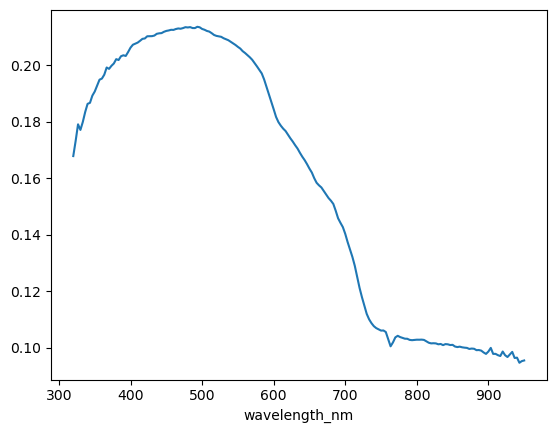

In [149]:
df_merge['Albedo'].plot()

In [152]:
df_1.index.names

FrozenList(['timestamp_utc', 'station', 'location', 'azimuth', 'depth', 'repetition', 'wavelength_nm', 'variable'])

In [143]:
wvs_interp = np.linspace(320, 950, 190)
spl = CubicSpline(df_temp_1.index.get_level_values('wavelength_nm').values, df_temp_1['Incident_mW/(m^2_nm)'].values)

temp_1_interp = spl(wvs_interp)

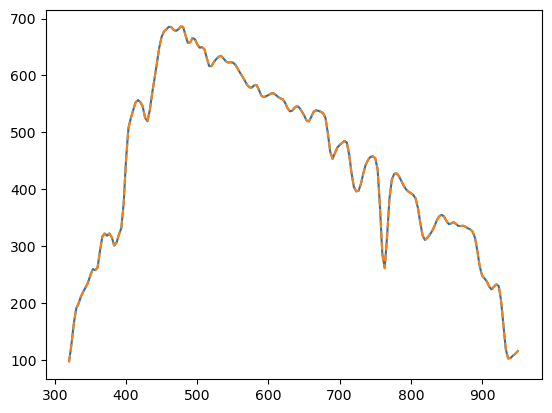

In [144]:
plt.plot(wvs_interp, temp_1_interp)
plt.plot(df_temp_1.index.get_level_values('wavelength_nm').values, df_temp_1['Incident_mW/(m^2_nm)'].values, '--')

In [137]:
df_temp_1

variable                                                                           Incident_mW/(m^2_nm)
timestamp_utc             station location azimuth depth repetition wavelength_nm                      
2025-07-16 14:24:01+00:00 2       Spond    140     NaN   0          319.614609                95.159150
                                                                    322.943169               124.038218
                                                                    326.272353               161.008332
                                                                    329.602148               188.867473
                                                                    332.932543               198.077912
...                                                                                                 ...
                                                                    940.147775               103.065013
                                                                    943.386179               107.189708
                                                                    946.622984               110.298404
                                                                    949.858177               114.460802
                                                                    953.091747               120.770672

[192 rows x 1 columns]

In [131]:
np.linspace(320, 950, 190)

array([320.        , 323.33333333, 326.66666667, 330.        ,
       333.33333333, 336.66666667, 340.        , 343.33333333,
       346.66666667, 350.        , 353.33333333, 356.66666667,
       360.        , 363.33333333, 366.66666667, 370.        ,
       373.33333333, 376.66666667, 380.        , 383.33333333,
       386.66666667, 390.        , 393.33333333, 396.66666667,
       400.        , 403.33333333, 406.66666667, 410.        ,
       413.33333333, 416.66666667, 420.        , 423.33333333,
       426.66666667, 430.        , 433.33333333, 436.66666667,
       440.        , 443.33333333, 446.66666667, 450.        ,
       453.33333333, 456.66666667, 460.        , 463.33333333,
       466.66666667, 470.        , 473.33333333, 476.66666667,
       480.        , 483.33333333, 486.66666667, 490.        ,
       493.33333333, 496.66666667, 500.        , 503.33333333,
       506.66666667, 510.        , 513.33333333, 516.66666667,
       520.        , 523.33333333, 526.66666667, 530.  

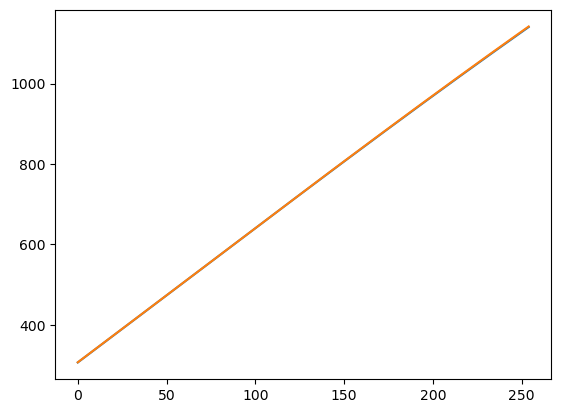

In [116]:
plt.plot(df_881E.index.get_level_values('wavelength_nm').unique().values)
plt.plot(df_881D.index.get_level_values('wavelength_nm').unique().values)

In [110]:
df_881D.index.get_level_values('wavelength_nm').unique()

Index([ 306.71087926664,  310.03151492541,  313.35293155712,  316.67511687875,
        319.99805860728,  323.32174445969,  326.64616215296,  329.97129940407,
           333.29714393,  336.62368344773,
       ...
       1117.01643451136, 1120.15904070567,    1123.29940625, 1126.43751886133,
       1129.57336625664, 1132.70693615291, 1135.83821626712, 1138.96719431625,
       1142.09385801728,              nan],
      dtype='float64', name='wavelength_nm', length=256)

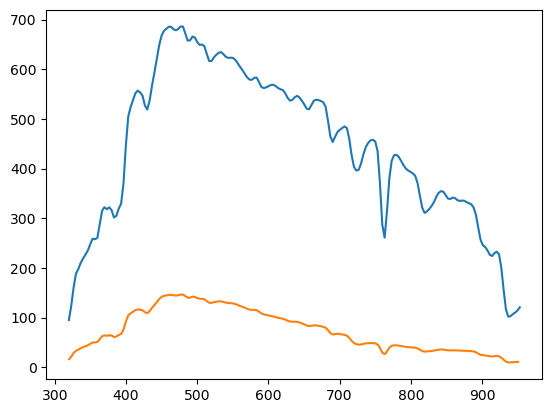

In [108]:
plt.plot('wavelength_nm', 'value', data=df_881E.query('variable=="Incident_mW/(m^2_nm)"').reset_index())
plt.plot('wavelength_nm', 'value', data=df_881D.query('variable=="Reflected_mW/(m^2_nm)"').reset_index())


In [84]:
df_881E

value
timestamp_utc             station location azimuth depth wavelength_nm variable                   
2025-07-16 14:24:01+00:00 2       Spond    140     NaN   0.000000      Incident_mW/(m^2_nm)    3.0
                                                         306.306837    Incident_mW/(m^2_nm)    NaN
                                                         309.632786    Incident_mW/(m^2_nm)    NaN
                                                         312.959405    Incident_mW/(m^2_nm)    NaN
                                                         316.286683    Incident_mW/(m^2_nm)    NaN
...                                                                                            ...
                                                         1128.090634   Incident_Status         0.0
                                                         1131.214336   Incident_Status         0.0
                                                         1134.335738   Incident_Status         0.0
                                                         1137.454827   Incident_Status         0.0
                                                         1140.571592   Incident_Status         0.0

[768 rows x 1 columns]

In [111]:
filename = 'contrasts_4A7F_2025-07-16_14-24-01_448_111_SAM_881D_SPECTRUM_CALIBRATED.dat'
# Experiment with reading in a file:
filepath = os.path.join(data_path, project_name, data_level, filename)

# Read file into a list with each line as an entry
with open(filepath, 'r') as f:
    ls_file = f.readlines()
    
# Pull the attributes into a dictionary
att_dict = {}
for i in range(len(ls_file)):
    if ls_file[i] in ['[Spectrum]\n', '[Attributes]\n', '[END] of [Attributes]\n']:
        continue
    elif ls_file[i] == '[DATA]\n':
        break
    else:
        att_dict[ls_file[i].split('=')[0].strip()] = ls_file[i].split('=')[1].strip()

# Create column names for data
col_names = [att_dict['Unit1'].split(maxsplit=2)[2].replace(' ', '_').lower(),
             att_dict['Unit2'].split(maxsplit=2)[2].replace(' ', '_'),
             att_dict['Unit3'].split(maxsplit=2)[2].replace(' ', '_'),
             att_dict['Unit4'].split(maxsplit=2)[2].replace(' ', '_'),]

# Read data in with pandas
df_in = pd.read_csv(filepath, sep='\s+', header=None, names=col_names, skiprows=i+1, nrows=len(ls_file)-i-3,
                   na_values='-NAN')

if att_dict['IDDevice']=='SAM_881D':
    if att_dict['CommentSub3']=='AL':
        df_in.rename(columns={col_names[1]: col_names[1].replace('Intensity', 'Reflected'),
                              col_names[2]: 'Reflected_' + col_names[2],
                              col_names[3]: 'Reflected_' + col_names[3]}, inplace=True)
    else:
        df_in.rename(columns={col_names[1]: col_names[1].replace('Intensity', 'Transmitted'),
                              col_names[2]: 'Transmitted_' + col_names[2],
                              col_names[3]: 'Transmitted_' + col_names[3]}, inplace=True)
elif att_dict['IDDevice']=='SAM_881E':
    df_in.rename(columns={col_names[1]: col_names[1].replace('Intensity', 'Incident'),
                          col_names[2]: 'Incident_' + col_names[2],
                          col_names[3]: 'Incident_' + col_names[3]}, inplace=True)

# Convert to long form
df_long = df_in.melt(id_vars='wavelength_nm')

# Add pressure and inclination data if present
if att_dict['IDDevice']=='SAM_881D':
    inc_press = np.zeros(4)*np.NaN
    if att_dict['InclValid']=='1':
        inc_press[0] = float(att_dict['InclV'])
        inc_press[1] = float(att_dict['InclX'])
        inc_press[2] = float(att_dict['InclY'])
    if att_dict['PressValid']=='1':
        inc_press[3] = float(att_dict['Pressure'])
    df_long = pd.concat([df_long, 
                         pd.DataFrame(data={'wavelength_nm': [np.NaN, np.NaN, np.NaN, np.NaN],
                                      'variable': ['InclV', 'InclX', 'InclY', 'Pressure'],
                                      'value': inc_press})])

# Add timestamp, station, location, azimuth, and depth columns
df_long['timestamp_utc'] = pd.Timestamp(att_dict['DateTime'], tz='UTC')
df_long['station'] = att_dict['Comment'][-1]
df_long['location'] = att_dict['CommentSub1']
df_long['azimuth'] = att_dict['CommentSub2'][2:]
df_long['depth'] = np.NaN


In [113]:
df_long.query('variable == "Reflected_mW/(m^2_nm)"')

wavelength_nm               variable  value             timestamp_utc  \
0         0.000000  Reflected_mW/(m^2_nm)    6.0 2025-07-16 14:24:01+00:00   
1       306.710879  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
2       310.031515  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
3       313.352932  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
4       316.675117  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
..             ...                    ...    ...                       ...   
251    1129.573366  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
252    1132.706936  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
253    1135.838216  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
254    1138.967194  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   
255    1142.093858  Reflected_mW/(m^2_nm)    NaN 2025-07-16 14:24:01+00:00   

    station location azimuth  depth  
0         2    Spond     140    NaN  
1         2    Spond     140    NaN  
2         2    Spond     140    NaN  
3         2    Spond     140    NaN  
4         2    Spond     140    NaN  
..      ...      ...     ...    ...  
251       2    Spond     140    NaN  
252       2    Spond     140    NaN  
253       2    Spond     140    NaN  
254       2    Spond     140    NaN  
255       2    Spond     140    NaN  

[256 rows x 8 columns]

In [73]:
df_long = df_in.melt(id_vars='wavelength_nm')

In [74]:
df_long

wavelength_nm               variable  value
0         0.000000  Reflected_mW/(m^2_nm)    6.0
1       306.710879  Reflected_mW/(m^2_nm)    NaN
2       310.031515  Reflected_mW/(m^2_nm)    NaN
3       313.352932  Reflected_mW/(m^2_nm)    NaN
4       316.675117  Reflected_mW/(m^2_nm)    NaN
..             ...                    ...    ...
763    1129.573366       Reflected_Status    0.0
764    1132.706936       Reflected_Status    0.0
765    1135.838216       Reflected_Status    0.0
766    1138.967194       Reflected_Status    0.0
767    1142.093858       Reflected_Status    0.0

[768 rows x 3 columns]

In [76]:
inc_press = np.zeros(4)*np.NaN
if att_dict['InclValid']=='1':
    inc_press[0] = float(att_dict['InclV'])
    inc_press[1] = float(att_dict['InclX'])
    inc_press[2] = float(att_dict['InclY'])
if att_dict['PressValid']=='1':
    inc_press[3] = float(att_dict['Pressure'])
pd.DataFrame(data={'wavelength_nm': [np.NaN, np.NaN, np.NaN, np.NaN],
                   'variable': ['InclV', 'InclX', 'InclY', 'Pressure'],
                   'value': inc_press})

wavelength_nm  variable   value
0            NaN     InclV  9.6800
1            NaN     InclX  0.0000
2            NaN     InclY  9.6800
3            NaN  Pressure -0.0073

In [46]:
att_dict

{'Version': '1',
 'IDData': '4A7F_2025-07-16_14-24-01_448_111',
 'IDDevice': 'SAM_881D',
 'IDDataType': 'SPECTRUM',
 'IDDataTypeSub1': 'CALIBRATED',
 'IDDataTypeSub2': '',
 'IDDataTypeSub3': '',
 'DateTime': '2025-07-16 14:24:01',
 'PositionLatitude': '0',
 'PositionLongitude': '0',
 'Comment': 'station2',
 'CommentSub1': 'Spond',
 'CommentSub2': 'az140',
 'CommentSub3': 'AL',
 'IDMethodType': 'SAMIP Control',
 'MethodName': 'SAMIP_5143',
 'Mission': 'No Mission',
 'MissionSub': '1',
 'RecordType': '0',
 'CalFactor': '1',
 'IDBasisSpec': '',
 'IDDataBack': 'DLAB_2024-01-12_13-35-25_618_586',
 'IDDataCal': 'DLAB_2024-01-17_13-40-29_072_207',
 'InclV': '9.68',
 'InclValid': '1',
 'InclX': '0',
 'InclY': '9.68',
 'IntegrationTime': '128',
 'P31': '-1',
 'P31e': '0',
 'PathLength': '+INF',
 'PressValid': '1',
 'Pressure': '-0.00730013500170301',
 'RAWDynamic': '65535',
 'Temperature': '-NAN',
 'Unit1': '$01 $01 Wavelength nm',
 'Unit2': '$03 $06 Intensity mW/(m^2 nm)',
 'Unit3': '$f0 $06 E

In [68]:
df_in.melt(id_vars=['timestamp_utc', 'station', 'location', 'azimuth', 'depth', 'wavelength_nm']).set_index(
    ['timestamp_utc', 'station', 'location', 'azimuth', 'depth', 'wavelength_nm', 'variable'])

value
timestamp_utc             station location azimuth depth wavelength_nm variable                    
2025-07-16 14:24:01+00:00 2       Spond    140     NaN   0.000000      Reflected_mW/(m^2_nm)    6.0
                                                         306.710879    Reflected_mW/(m^2_nm)    NaN
                                                         310.031515    Reflected_mW/(m^2_nm)    NaN
                                                         313.352932    Reflected_mW/(m^2_nm)    NaN
                                                         316.675117    Reflected_mW/(m^2_nm)    NaN
...                                                                                             ...
                                                         1129.573366   Reflected_Status         0.0
                                                         1132.706936   Reflected_Status         0.0
                                                         1135.838216   Reflected_Status         0.0
                                                         1138.967194   Reflected_Status         0.0
                                                         1142.093858   Reflected_Status         0.0

[768 rows x 1 columns]

In [51]:
pd.Timestamp(att_dict['DateTime'], tz='UTC')

Timestamp('2025-07-16 14:24:01+0000', tz='UTC')

In [64]:
df_in

wavelength_nm  Reflected_mW/(m^2_nm)  Reflected_Error_mW/(m^2_nm)  \
0         0.000000                    6.0                            0   
1       306.710879                    NaN                            0   
2       310.031515                    NaN                            0   
3       313.352932                    NaN                            0   
4       316.675117                    NaN                            0   
..             ...                    ...                          ...   
251    1129.573366                    NaN                            0   
252    1132.706936                    NaN                            0   
253    1135.838216                    NaN                            0   
254    1138.967194                    NaN                            0   
255    1142.093858                    NaN                            0   

     Reflected_Status             timestamp_utc station location azimuth  
0                   0 2025-07-16 14:24:01+00:00       2    Spond     140  
1                   0 2025-07-16 14:24:01+00:00       2    Spond     140  
2                   0 2025-07-16 14:24:01+00:00       2    Spond     140  
3                   0 2025-07-16 14:24:01+00:00       2    Spond     140  
4                   0 2025-07-16 14:24:01+00:00       2    Spond     140  
..                ...                       ...     ...      ...     ...  
251                 0 2025-07-16 14:24:01+00:00       2    Spond     140  
252                 0 2025-07-16 14:24:01+00:00       2    Spond     140  
253                 0 2025-07-16 14:24:01+00:00       2    Spond     140  
254                 0 2025-07-16 14:24:01+00:00       2    Spond     140  
255                 0 2025-07-16 14:24:01+00:00       2    Spond     140  

[256 rows x 8 columns]

In [44]:
df_in.dtypes

Wavelength_nm            float64
Intensity_mW/(m^2_nm)    float64
Error_mW/(m^2_nm)          int64
Status                     int64
dtype: object

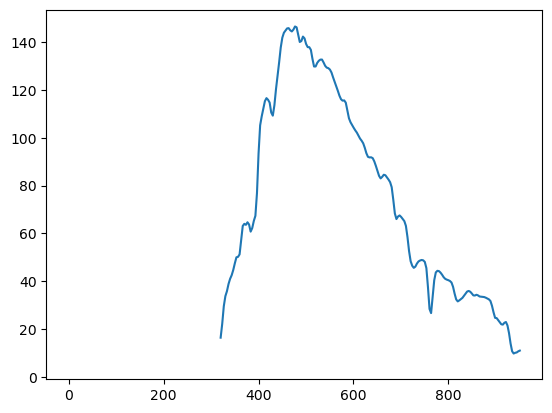

In [45]:
plt.plot('Wavelength_nm', 'Intensity_mW/(m^2_nm)', data=df_in)

In [21]:
att_dict

{'Version': '1',
 'IDData': '4A7F_2025-07-16_14-24-01_448_111',
 'IDDevice': 'SAM_881D',
 'IDDataType': 'SPECTRUM',
 'IDDataTypeSub1': 'CALIBRATED',
 'IDDataTypeSub2': '',
 'IDDataTypeSub3': '',
 'DateTime': '2025-07-16 14:24:01',
 'PositionLatitude': '0',
 'PositionLongitude': '0',
 'Comment': 'station2',
 'CommentSub1': 'Spond',
 'CommentSub2': 'az140',
 'CommentSub3': 'AL',
 'IDMethodType': 'SAMIP Control',
 'MethodName': 'SAMIP_5143',
 'Mission': 'No Mission',
 'MissionSub': '1',
 'RecordType': '0',
 'CalFactor': '1',
 'IDBasisSpec': '',
 'IDDataBack': 'DLAB_2024-01-12_13-35-25_618_586',
 'IDDataCal': 'DLAB_2024-01-17_13-40-29_072_207',
 'InclV': '9.68',
 'InclValid': '1',
 'InclX': '0',
 'InclY': '9.68',
 'IntegrationTime': '128',
 'P31': '-1',
 'P31e': '0',
 'PathLength': '+INF',
 'PressValid': '1',
 'Pressure': '-0.00730013500170301',
 'RAWDynamic': '65535',
 'Temperature': '-NAN',
 'Unit1': '$01 $01 Wavelength nm',
 'Unit2': '$03 $06 Intensity mW/(m^2 nm)',
 'Unit3': '$f0 $06 E

In [31]:
pd.read_csv(filepath, sep='\s+', header=None, names=col_names, skiprows=i, footer=2)

NameError: name 'col_names' is not defined

In [27]:
i

43

In [28]:
len(ls_file)

302

In [30]:
ls_file[len(ls_file)-3]

' 1142.09385801728 -NAN 0 0\n'

In [ ]:
def read_msda_file(filename):
    